## CSCE 676 :: Data Mining and Analysis :: Texas A&M University :: Fall 2025

*Project Title*: **Discovering Hidden Patterns in Protein Sequences**

*Team Name*: **Motif Hunters**

*Team Members*: **Uday Reddy (436000929), Aayush Yadav (535005643), Yash Phatak (136004827)**

## Motivation

*   Proteins are sequences composed of amino acids.

*   Two proteins can look completely different, but still do the same job in the cell. Some short amino-acid sequences — called motifs — occur repeatedly in proteins that share a biological role, like binding to metal ions or breaking down sugars.


* With hundreds of millions of proteins discovered, manually finding these motifs or grouping proteins by function is impossible.
So the problem is:


*“Given millions of protein sequences, how can we automatically find which ones are similar in function and what repeating sequence patterns (motifs) make them similar?”*

## Impact

*   Identifying similar proteins helps scientists predict the function of unknown proteins in new viruses or bacteria.

* Motif discovery can reveal targets for drug design — for example, all proteins that share a certain binding motif might interact with the same type of molecule (like an antibiotic or enzyme inhibitor).


* The better we can mine protein data, the faster we can understand life, diseases, and potential treatments.

## Dataset Used

Dataset Link: [UniProt Swiss Prot](https://www.uniprot.org/uniprotkb)

We used the Swiss-Prot (Reviewed) dataset which contains manually verified proteins with accurate labels (e.g., function, organism)	and contains about ~573K entries.

Each entry contains:

*   Protein sequence (the chain of amino acids, e.g., “MVKVGVNGFGRIGRL…”)
*   Organism type: Bacteria, Virus, Eukaryote, Archaea
*   Optional metadata: function, length, structure ID, etc.

Each sequence has a unique, high-quality FASTA entry and clear metadata.


### Note

The file path to the dataset must be specified correctly. We have submitted the FASTA file containing protein sequences and a zip file containing Pfam outputs in JSON format corresponding to different clusters. Please ensure these file paths are correctly specified.

### Download required modules

In [ ]:
!pip install biopython
!pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 32.3 MB/s eta 0:00:0000:0100:01


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import pandas as pd
import json
import os

## Load the UniProt Swiss Prot Dataset

In [ ]:
from Bio import SeqIO

file_path = '/kaggle/input/uniprot-swiss-prot-dataset/uniprot_sprot.fasta'

# Parse the FASTA file
records = list(SeqIO.parse(file_path, 'fasta'))

print(f"Loaded {len(records)} sequences from {file_path}")

# Display the first 5 records
print("\nFirst 5 records:")
for i, record in enumerate(records[:5]):
    print(f"Record {i+1}:")
    print(f"  ID: {record.id}")
    print(f"  Name: {record.name}")
    print(f"  Description: {record.description}")
    print(f"  Sequence length: {len(record.seq)}")
    print(f"  First 50 characters of sequence: {str(record.seq)[:50]}...")
    print("---")

Loaded 573661 sequences from /kaggle/input/uniprot-swiss-prot-dataset/uniprot_sprot.fasta

First 5 records:
Record 1:
  ID: sp|Q6GZX4|001R_FRG3G
  Name: sp|Q6GZX4|001R_FRG3G
  Description: sp|Q6GZX4|001R_FRG3G Putative transcription factor 001R OS=Frog virus 3 (isolate Goorha) OX=654924 GN=FV3-001R PE=4 SV=1
  Sequence length: 256
  First 50 characters of sequence: MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQVECPK...
---
Record 2:
  ID: sp|Q6GZX3|002L_FRG3G
  Name: sp|Q6GZX3|002L_FRG3G
  Description: sp|Q6GZX3|002L_FRG3G Uncharacterized protein 002L OS=Frog virus 3 (isolate Goorha) OX=654924 GN=FV3-002L PE=4 SV=1
  Sequence length: 320
  First 50 characters of sequence: MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQTCASG...
---
Record 3:
  ID: sp|Q197F8|002R_IIV3
  Name: sp|Q197F8|002R_IIV3
  Description: sp|Q197F8|002R_IIV3 Uncharacterized protein 002R OS=Invertebrate iridescent virus 3 OX=345201 GN=IIV3-002R PE=4 SV=1
  Sequence length: 458
  First 50 characters of sequence: MASNTVSA

#### Interpreting record attributes

**Name:** Protein Name

**Description:** Protein Description includes the following information -

* *Organism Species (OS)*

* *Organism Taxonomy ID (OX):* A unique identifier for the organism in the database.

* *Gene Name (GN):* Name of the gene encoding the protein.

* *Protein Existence (PE):* An indicator of the experimental evidence for the existence of the protein (e.g., predicted, inferred, experimental).

* *Sequence Version (SV)*

*Protein Sequence:* The protein sequence comprises of a sequence of amino acids where each character corresponds to a specific amino acid.


## Data Preprocessing

### Prepare Protein Sequences

We extract the amino acid sequences from the loaded `records` and convert them into a format suitable for feature extraction.


In [ ]:
protein_sequences = []

for record in records:
    protein_sequences.append(str(record.seq))

print(f"Extracted {len(protein_sequences)} protein sequences.")
print("\nFirst 5 extracted sequences:")
for i, seq in enumerate(protein_sequences[:5]):
    print(f"Sequence {i+1}: {seq[:70]}...")

Extracted 573661 protein sequences.

First 5 extracted sequences:
Sequence 1: MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQVECPKAPVEWNNPPSEKGLIVGHFS...
Sequence 2: MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQTCASGFCTSQPLCARIKKTQVCGLR...
Sequence 3: MASNTVSAQGGSNRPVRDFSNIQDVAQFLLFDPIWNEQPGSIVPWKMNREQALAERYPELQTSEPSEDYS...
Sequence 4: MYQAINPCPQSWYGSPQLEREIVCKMSGAPHYPNYYPVHPNALGGAWFDTSLNARSLTTTPSLTTCTPPS...
Sequence 5: MARPLLGKTSSVRRRLESLSACSIFFFLRKFCQKMASLVFLNSPVYQMSNILLTERRQVDRAMGGSDDDG...


We randomly sample a subset of `100000` protein sequences due to resource contraints and for efficiency reasons.

In [ ]:
import random

def get_samples(sample_size):
    random.seed(42)
    sampled_sequences = random.sample(protein_sequences, sample_size)

    print(f"Sampled {len(sampled_sequences)} protein sequences.")
    print("\nFirst 5 sampled sequences:")
    for i, seq in enumerate(sampled_sequences[:5]):
        print(f"Sequence {i+1}: {seq[:70]}...")

    return sampled_sequences

sampled_sequences = get_samples(100000)

Sampled 100000 protein sequences.

First 5 sampled sequences:
Sequence 1: MGKEKTHINIVVIGHVDSGKSTTTGHLIYKLGGIDKRVIERFEKEAAEMNKRSFKYAWVLDKLKAERERG...
Sequence 2: MDYLDLGPYSSASGTVRLPGSKSISNRVLLLAALAEGETTITNLLDSDDTRVMLDALGKLGVKLARDGDT...
Sequence 3: MIWHVQNENFILDSTRIFMKAFHLLLFHGSFIFPECILIFGLILLLMIDSTSDQKDIPWLYFISSTSLVM...
Sequence 4: MQQIMVSGTVAFLVSIFLTPVLIRYFTNRQLGQEIREEGLQSHLRKRGTPTMGGIAIIAGIVVAYVFTNI...
Sequence 5: MPLLDSFCVDHTIMNAPGVRLAKTMDTPKGDKICVFDLRFCKPNETMMPERGTHTLEHLFAGFMRDHLNR...


### Extract Sequence Features (3-mers)

Now, we compute the counts of all possible 3-mer (tripeptide) substrings for each protein sequence. This will transform each sequence into a numerical vector where each dimension corresponds to the count of a specific tripeptide.

We consider 3-mers because of their biological significance in differentiating proteins. Many functional motifs, binding sites, and structural signatures appear as short local patterns of length 3–5. 3-mers are widely used in bioinformatics literature -

* protein family classification
* enzyme function prediction
* provide a reasonable trade-off between information richness, computational feasibility, and generalization


In [ ]:
def get_k_mers(sequence, k):
    return [sequence[i:i + k] for i in range(len(sequence) - k + 1)]

print("Defined get_k_mers function.")

Defined get_k_mers function.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Apply get_k_mers to each protein sequence to get a list of 3-mer lists
k = 3
protein_3mers_lists = [get_k_mers(seq, k) for seq in sampled_sequences]

# Initialize CountVectorizer
# The analyzer is set to a lambda function that returns the pre-tokenized list directly
# lowercase is set to False to preserve amino acid case
vectorizer = CountVectorizer(analyzer=lambda x: x, lowercase=False)

# Fit and transform the list of 3-mer lists
X_features = vectorizer.fit_transform(protein_3mers_lists)

print(f"Shape of X_features (proteins x 3-mers): {X_features.shape}")

# Get feature names (the 3-mers themselves)
feature_names = vectorizer.get_feature_names_out()
print(f"\nTotal number of unique 3-mers: {len(feature_names)}")
print(f"Sample of 3-mer feature names (first 10): {feature_names[:10]}")


Shape of X_features (proteins x 3-mers): (100000, 9138)

Total number of unique 3-mers: 9138
Sample of 3-mer feature names (first 10): ['AAA' 'AAC' 'AAD' 'AAE' 'AAF' 'AAG' 'AAH' 'AAI' 'AAK' 'AAL']


### Compute TF-IDF Vectors

We apply Term Frequency-Inverse Document Frequency (TF-IDF) transformation to the previously computed 3-mer count vectors (`X_features`) to convert them into TF-IDF vectors.


In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

# Create an instance of TfidfTransformer
tfidf_transformer = TfidfTransformer()

# Apply TF-IDF transformation to X_features
X_tfidf = tfidf_transformer.fit_transform(X_features)

print(f"Shape of X_tfidf (proteins x 3-mers TF-IDF): {X_tfidf.shape}")

Shape of X_tfidf (proteins x 3-mers TF-IDF): (100000, 9138)


### Reduce Dimensionality (PCA)

We apply Principal Component Analysis (PCA) to the TF-IDF vectors (`X_tfidf`) to reduce their dimensionality for efficient clustering. Post PCA, the number of features are reduced to `50` per protein which preserves `~6%` variance.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA

# Instantiate PCA with n_components=50 to reduce dimensionality
pca = PCA(n_components=50, random_state=42)

# Fit PCA to the TF-IDF features and transform them
X_pca = pca.fit_transform(X_tfidf.toarray())

print(f"Original shape of X_tfidf: {X_tfidf.shape}")
print(f"Shape of X_pca after dimensionality reduction: {X_pca.shape}")
print(f"Number of components selected by PCA: {pca.n_components_}")
print(f"Total explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")

Original shape of X_tfidf: (100000, 9138)
Shape of X_pca after dimensionality reduction: (100000, 50)
Number of components selected by PCA: 50
Total explained variance ratio: 0.0602


## HDBSCAN Clustering

We've applied HDBSCAN to cluster the proteins based on their PCA-reduced features. The majority of sequences were classified as noise, which aligns with findings in similar studies.

We tried to construct a protein similarity graph, generated Node2Vec embeddings, and then applied clustering to these graph-based representations. While we explored Node2Vec graph embeddings, we prioritized HDBSCAN because proteins are fundamentally encoded in their amino acid sequence composition and motifs — relationships that HDBSCAN directly preserves.


We apply the HDBSCAN clustering algorithm to group the proteins based on their extracted 3-mer -> TF-IDF -> PCA feature vectors.


First, we visualize the k-distance plot to ensure the PCA embeddings are healthy for clustering. The k-distance plot shows variation in densities as the 5-NN distance varies from `0.0` to `0.4+` implying the PCA embeddings are healthy for clustering.

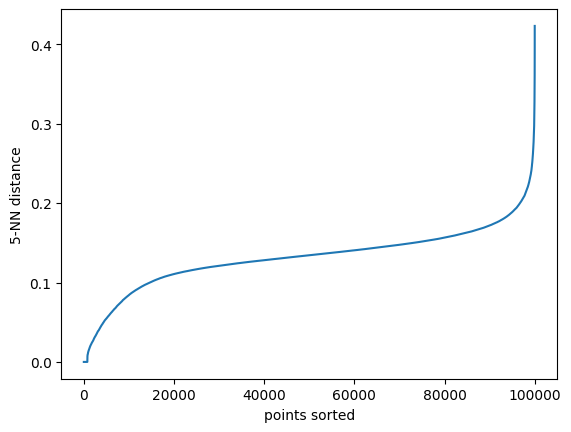

In [ ]:
from sklearn.neighbors import NearestNeighbors

def compute_k_distance_plot(subset):
    nbrs = NearestNeighbors(n_neighbors=6, metric='euclidean').fit(subset)
    dists, _ = nbrs.kneighbors(subset)
    k_dist = np.sort(dists[:, -1])  # 5-NN distance sorted
    plt.plot(k_dist)
    plt.xlabel('points sorted')
    plt.ylabel('5-NN distance')
    plt.show()

compute_k_distance_plot(X_pca)

We execute HDBSCAN for different values of `min_samples` and `min_cluster_sizes` for a subset of `10000` protein sequences.

In [ ]:
import hdbscan

sample_sequences_10k = get_samples(10000)

k_10k = 3
protein_3mers_lists_10k = [get_k_mers(seq, k) for seq in sample_sequences_10k]

X_features_10k = vectorizer.fit_transform(protein_3mers_lists_10k)
X_tfidf_10k = tfidf_transformer.fit_transform(X_features_10k)
X_pca_10k = pca.fit_transform(X_tfidf_10k.toarray())

print(f"----------------------")

min_samples = [5, 10, 25, 50]
min_cluster_sizes = [5, 10, 25, 50]

for min_sample in min_samples:
    for min_cluster_size in min_cluster_sizes:
        # Instantiate HDBSCAN. Using default parameters for initial exploration.
        # Consider adjusting min_cluster_size and min_samples for different clustering characteristics.
        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                    min_samples=min_sample,
                                    metric='euclidean',
                                    cluster_selection_epsilon=0.0)

        # Fit the model to the PCA features
        cluster_labels = clusterer.fit_predict(X_pca_10k)

        print(f"Min Samples - {min_sample} Min Cluster Size - {min_cluster_size}")
        print(f"Number of clusters found (excluding noise): {len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)}")
        print(f"Number of noise points (-1 label): {list(cluster_labels).count(-1)}")
        print(f"First 10 cluster labels: {cluster_labels[:10]}")
        print(f"----------------------")

Sampled 10000 protein sequences.

First 5 sampled sequences:
Sequence 1: MGKEKTHINIVVIGHVDSGKSTTTGHLIYKLGGIDKRVIERFEKEAAEMNKRSFKYAWVLDKLKAERERG...
Sequence 2: MDYLDLGPYSSASGTVRLPGSKSISNRVLLLAALAEGETTITNLLDSDDTRVMLDALGKLGVKLARDGDT...
Sequence 3: MIWHVQNENFILDSTRIFMKAFHLLLFHGSFIFPECILIFGLILLLMIDSTSDQKDIPWLYFISSTSLVM...
Sequence 4: MQQIMVSGTVAFLVSIFLTPVLIRYFTNRQLGQEIREEGLQSHLRKRGTPTMGGIAIIAGIVVAYVFTNI...
Sequence 5: MPLLDSFCVDHTIMNAPGVRLAKTMDTPKGDKICVFDLRFCKPNETMMPERGTHTLEHLFAGFMRDHLNR...
----------------------
Min Samples - 5 Min Cluster Size - 5
Number of clusters found (excluding noise): 2
Number of noise points (-1 label): 0
First 10 cluster labels: [1 1 1 1 1 1 1 1 1 1]
----------------------
Min Samples - 5 Min Cluster Size - 10
Number of clusters found (excluding noise): 2
Number of noise points (-1 label): 0
First 10 cluster labels: [1 1 1 1 1 1 1 1 1 1]
----------------------
Min Samples - 5 Min Cluster Size - 25
Number of clusters found (excluding noise): 2
Number of noise point

Observing the outputs for different sets of `min_samples` and `min_cluster_size`, we further confirm that the feature embeddings are suitable for clustering, as we obtain fairly consistent outputs.

Executing HDBSCAN for `100k` protein sequences with `min_samples = 10` and `min_cluster_size = 10`.

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10,
                            min_samples=10,
                            metric='euclidean',
                            cluster_selection_epsilon=0.0)

# Fit the model to the PCA features
cluster_labels = clusterer.fit_predict(X_pca)

print(f"Number of clusters found (excluding noise): {len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)}")
print(f"Number of noise points (-1 label): {list(cluster_labels).count(-1)}")
print(f"First 10 cluster labels: {cluster_labels[:10]}")

Number of clusters found (excluding noise): 609
Number of noise points (-1 label): 83700
First 10 cluster labels: [143  -1 106  -1  -1  -1  -1  -1  -1 345]


We can observe that HDBSCAN results in `609` clusters and `83700 (~84%)` noisy points which corroborate the findings of existing studies that cite `5% - 30%` sequences forming clusters and `70% - 95%` marked as noise.

#### High Noise Percentage is Expected
State-of-the-art protein language models (ESM-2, ProtT5, ProtBert, etc.) embed proteins into a manifold where:

* Most sequences are unique or nearly unique
* Only certain protein families form clear density regions

#### Why so many clusters?

* Protein families, domains, and motifs naturally produce hundreds of such clusters.
* These could represent homologous groups, local structural motifs, enzyme subclasses, or conserved families.

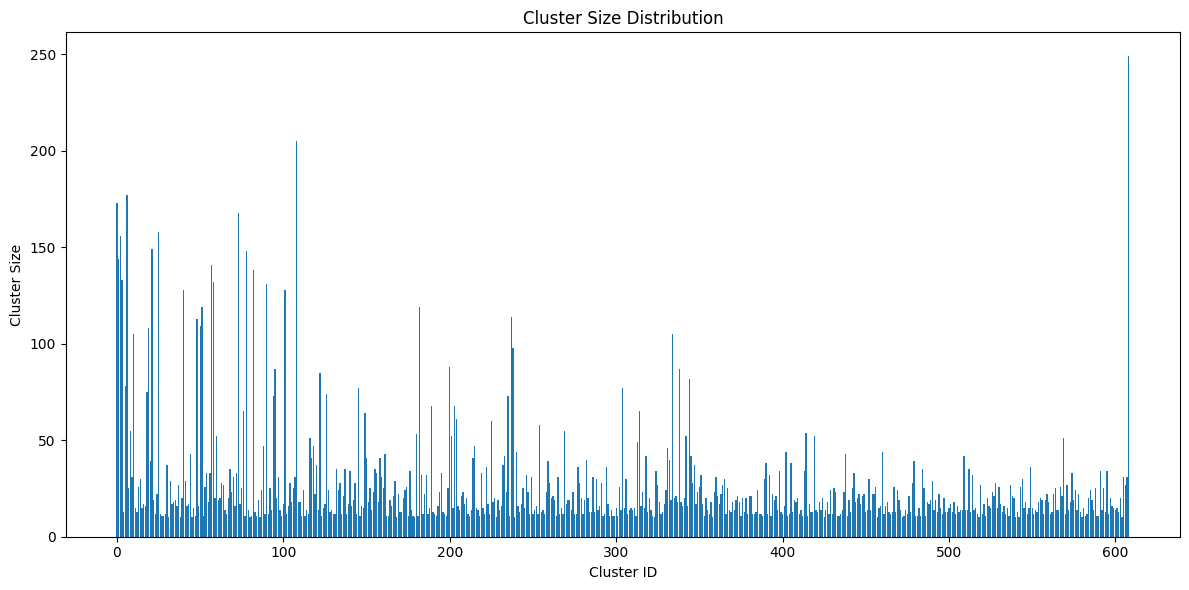

In [ ]:
# For each non-noise cluster, calculate the number of proteins assigned to it
cluster_sizes = Counter([label for label in cluster_labels if label != -1])

cluster_ids = list(cluster_sizes.keys())
sizes = list(cluster_sizes.values())

plt.figure(figsize=(12, 6))
plt.bar(cluster_ids, sizes)
plt.xlabel("Cluster ID")
plt.ylabel("Cluster Size")
plt.title("Cluster Size Distribution")
plt.tight_layout()
plt.show()

We can observe many small clusters which implies high diversity in proteins. There are few large clusters which could indicate common protein families that occur frequently across species.

### Visualizing Clusters

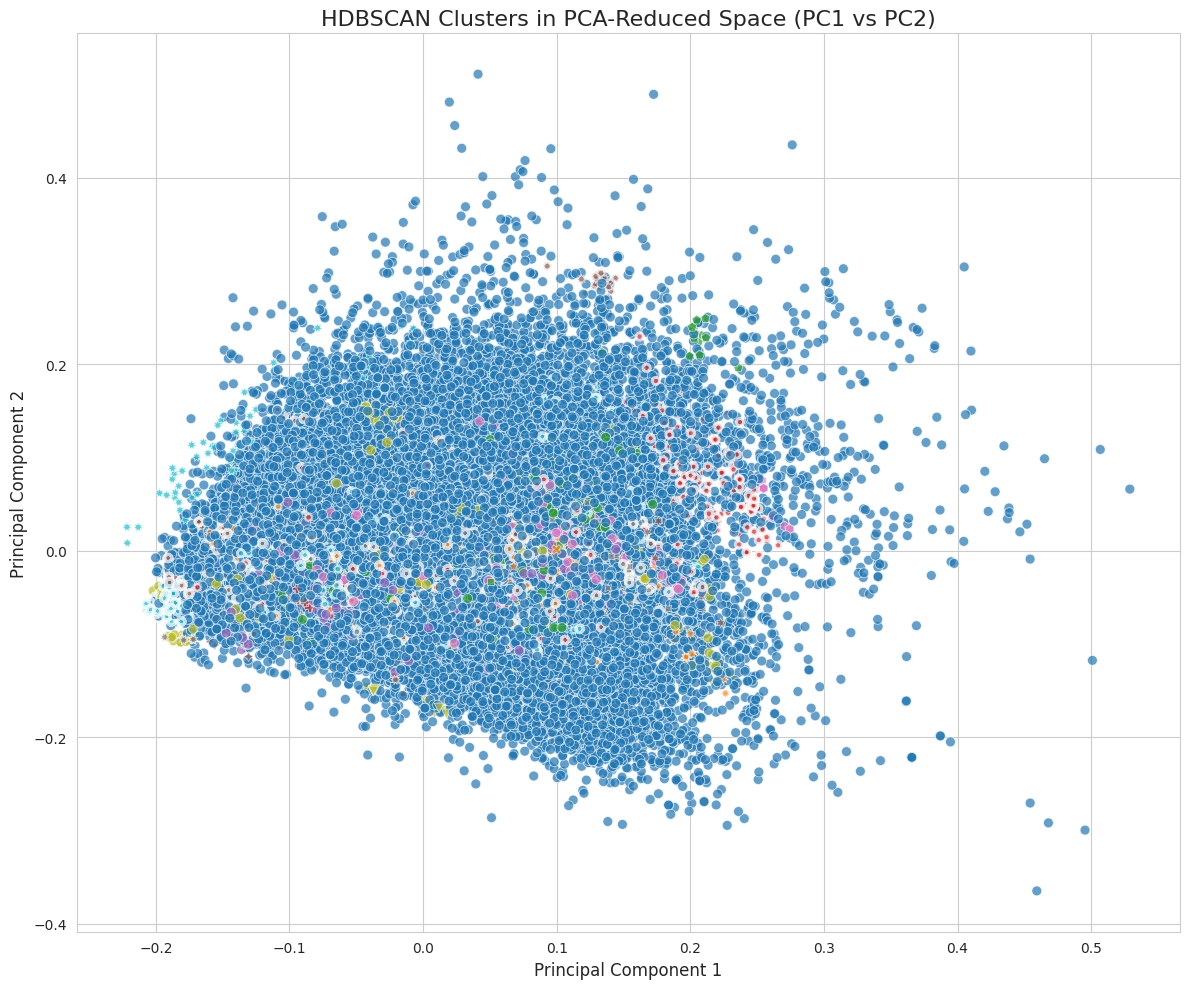

In [ ]:
# Create a DataFrame for easier plotting with seaborn
df_pca = pd.DataFrame(X_pca[:, :2], columns=['PC1', 'PC2'])
df_pca['Cluster'] = cluster_labels

# Set a style for better aesthetics
sns.set_style('whitegrid')

plt.figure(figsize=(12, 10))

# Plot the clusters using seaborn's scatterplot
sns.scatterplot(
    data=df_pca,
    x='PC1',
    y='PC2',
    hue='Cluster',
    palette='viridis' if -1 not in cluster_labels else 'tab10',
    style='Cluster' if -1 in cluster_labels else None,
    s=50, # Marker size
    alpha=0.7, # Transparency
    legend=False
)

plt.title('HDBSCAN Clusters in PCA-Reduced Space (PC1 vs PC2)', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.tight_layout()
plt.show()

### Characterizing Clusters by Sequence Length

Now, we consider certain clusters for further analysis. We find top 5 clusters based on stability and size.

In [ ]:
sequence_lengths = [len(seq) for seq in sampled_sequences]

# Create a DataFrame for plotting
df_lengths_clusters = pd.DataFrame({
    'Sequence_Length': sequence_lengths,
    'Cluster': cluster_labels
})

display(df_lengths_clusters.head())

,Sequence_Length,Cluster
0,447,143
1,434,-1
2,510,106
3,366,-1
4,171,-1


### Top 5 Stable Clusters

In [ ]:
# Get the cluster persistence scores. Note: cluster_persistence_ is ordered by cluster ID.
# Exclude the noise cluster (-1) from stability consideration, as it doesn't have a persistence score.
cluster_ids = sorted([c for c in clusterer.labels_ if c != -1])

# Create a mapping of cluster ID to its persistence score
# The clusterer.cluster_persistence_ array is indexed by cluster ID starting from 0
# So, if cluster_labels are 0, 1, 2, their persistence scores will be at indices 0, 1, 2 respectively.
# We only consider clusters that actually exist in the persistence array

# First, get unique non-noise clusters that have persistence scores
actual_clusters_with_persistence = [c for c in np.unique(cluster_labels) if c != -1 and c < len(clusterer.cluster_persistence_)]

# Create a dictionary to store cluster ID and its persistence
cluster_stability = {
    cluster_id: clusterer.cluster_persistence_[cluster_id]
    for cluster_id in actual_clusters_with_persistence
}

# Convert to a DataFrame for easier sorting and display
df_stability = pd.DataFrame(list(cluster_stability.items()), columns=['Cluster_ID', 'Persistence_Score'])

# Sort by persistence score in descending order
df_stability = df_stability.sort_values(by='Persistence_Score', ascending=False)

print("Top 5 Most Stable HDBSCAN Clusters:")
display(df_stability.head(5))

Top 5 Most Stable HDBSCAN Clusters:


,Cluster_ID,Persistence_Score
0,0,1.0
409,409,1.0
402,402,1.0
403,403,1.0
404,404,1.0


The top 5 most stable clusters have a persistence score of `1`. The persistence of a cluster measures how stable that cluster is across different density levels during the hierarchical condensation step. This helps in measuring cluster quality. These clusters are good candidates for further analysis.

Top 5 most stable cluster IDs: [0, 409, 402, 403, 404]


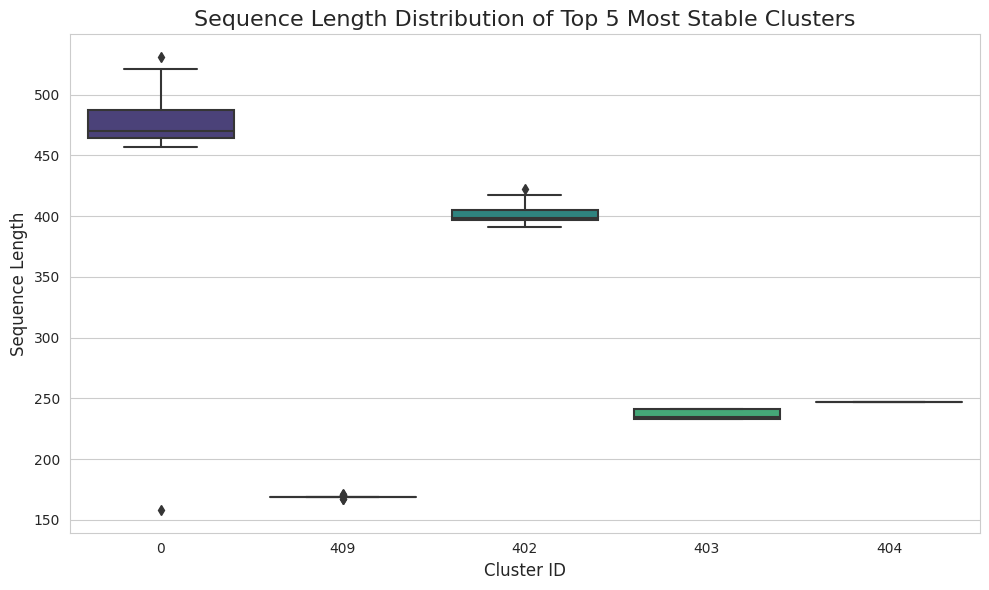

In [ ]:
# Extract the 'Cluster_ID' from the first 5 rows of the df_stability DataFrame
top_5_stable_cluster_ids = df_stability['Cluster_ID'].head(5).tolist()

print(f"Top 5 most stable cluster IDs: {top_5_stable_cluster_ids}")

# Filter the df_lengths_clusters DataFrame for these clusters
df_top_stable_clusters = df_lengths_clusters[df_lengths_clusters['Cluster'].isin(top_5_stable_cluster_ids)]

def plot_box_plot(data, order, title):
    # Create a box plot
    sns.set_style('whitegrid')

    plt.figure(figsize=(10, 6))

    sns.boxplot(
        x='Cluster',
        y='Sequence_Length',
        data=data,
        palette='viridis',
        order=order # Ensure clusters are plotted in order of stability
    )

    # Set the title of the plot
    plt.title(title, fontsize=16)

    # 5. Label the x-axis and y-axis
    plt.xlabel('Cluster ID', fontsize=12)
    plt.ylabel('Sequence Length', fontsize=12)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    # Display the plot
    plt.show()

plot_box_plot(df_top_stable_clusters,
              top_5_stable_cluster_ids,
              'Sequence Length Distribution of Top 5 Most Stable Clusters')

**Observations**

From the sequence length distribution, we can observe that protein sequences in each cluster have a tight bound with some outliers. This implies that sequence length is an important factor in clustering proteins. Furthermore, the sequence lengths across different clusters do not overlap which further strengthens the importance of sequence length as a distinguishing factor to group proteins. This suggests true biological separation.

### Top 5 Smallest and Largest Clusters

The same observation holds true for the top 5 largest and smallest clusters where proteins share similar sequence lengths.

In [ ]:
# Convert Counter to a list of (cluster_id, size) tuples
cluster_size_list = list(cluster_sizes.items())

# Sort by size in descending order for largest clusters
largest_clusters = sorted(cluster_size_list, key=lambda item: item[1], reverse=True)

# Filter out singletons (clusters with size 1) and sort by size in ascending order for smallest clusters
smallest_clusters = sorted([item for item in cluster_size_list if item[1] > 1], key=lambda item: item[1])

top_5_largest_cluster_ids = []
top_5_smallest_cluster_ids = []

for i, (cluster_id, size) in enumerate(largest_clusters[:5]):
    top_5_largest_cluster_ids.append(cluster_id)

if len(smallest_clusters) == 0:
    print("  No non-singleton clusters found.")
else:
    for i, (cluster_id, size) in enumerate(smallest_clusters[:5]):
        top_5_smallest_cluster_ids.append(cluster_id)

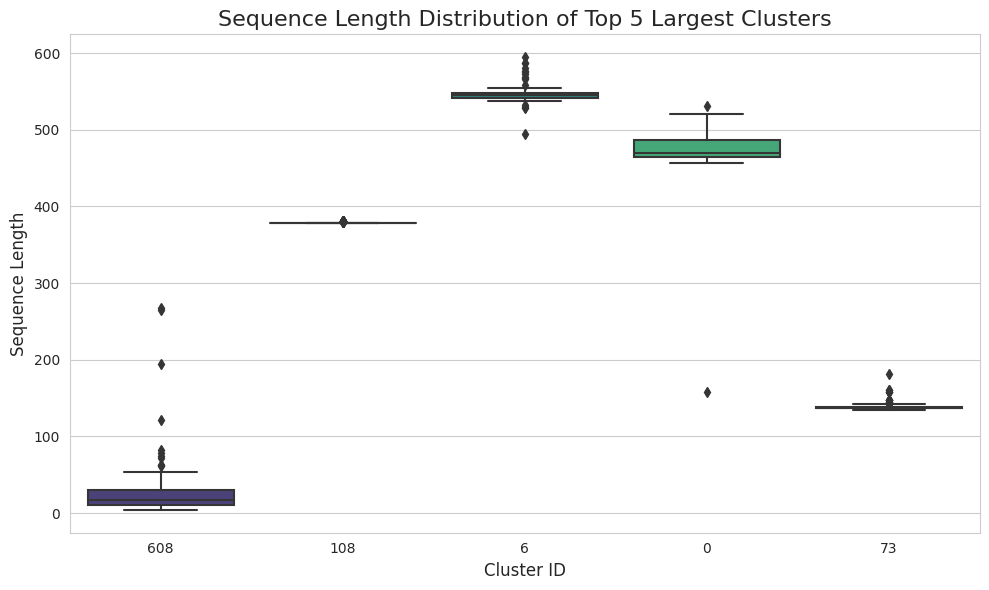

In [ ]:
df_top_largest_clusters = df_lengths_clusters[df_lengths_clusters['Cluster'].isin(top_5_largest_cluster_ids)]

plot_box_plot(df_top_largest_clusters,
              top_5_largest_cluster_ids,
              'Sequence Length Distribution of Top 5 Largest Clusters')

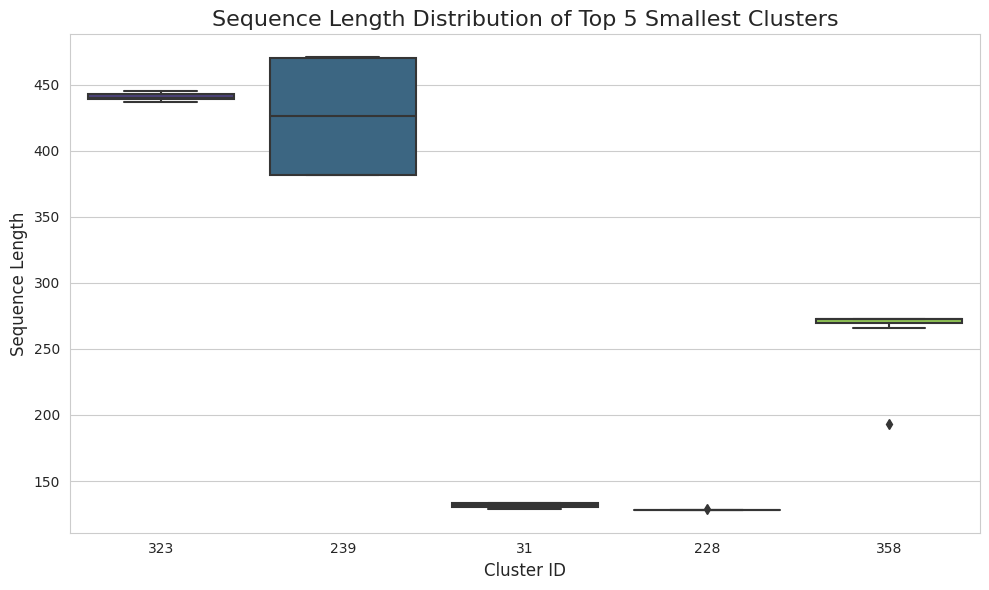

In [ ]:
df_top_smallest_clusters = df_lengths_clusters[df_lengths_clusters['Cluster'].isin(top_5_smallest_cluster_ids)]

plot_box_plot(df_top_smallest_clusters,
              top_5_smallest_cluster_ids,
              'Sequence Length Distribution of Top 5 Smallest Clusters')

## Analyzing Cluster Statistics

### Extracting Protein Descriptions

In [ ]:
sequence_to_description_map = {str(record.seq): record.description for record in records}

sampled_descriptions = []
for seq in sampled_sequences:
    sampled_descriptions.append(sequence_to_description_map.get(seq, ""))

for i, desc in enumerate(sampled_descriptions[:5]):
    print(f"Description {i+1}: {desc}\n")

Description 1: sp|Q41803|EF1A_MAIZE Elongation factor 1-alpha OS=Zea mays OX=4577 GN=EF1A PE=3 SV=1

Description 2: sp|B1JXR9|AROA_BURO0 3-phosphoshikimate 1-carboxyvinyltransferase OS=Burkholderia orbicola (strain MC0-3) OX=406425 GN=aroA PE=3 SV=1

Description 3: sp|P0CC59|NU2C2_DRIGR NAD(P)H-quinone oxidoreductase subunit 2 B, chloroplastic OS=Drimys granadensis OX=224735 GN=ndhB2 PE=3 SV=1

Description 4: sp|Q8NNN2|MRAY_CORGL Phospho-N-acetylmuramoyl-pentapeptide-transferase OS=Corynebacterium glutamicum (strain ATCC 13032 / DSM 20300 / JCM 1318 / BCRC 11384 / CCUG 27702 / LMG 3730 / NBRC 12168 / NCIMB 10025 / NRRL B-2784 / 534) OX=196627 GN=mraY PE=3 SV=1

Description 5: sp|A7GWQ0|LUXS_CAMC5 S-ribosylhomocysteine lyase OS=Campylobacter curvus (strain 525.92) OX=360105 GN=luxS PE=3 SV=1



In [ ]:
# Creating a Dataframe to study cluster statistics
import re

parsed_data = []

for i, (description, cluster) in enumerate(zip(sampled_descriptions, cluster_labels)):
    protein_name = description.split('OS=')[0].strip() if 'OS=' in description else description.strip()

    # Extract Organism Species (OS)
    os_match = re.search(r'OS=([^\s]+(?:\s[^\s]+)*?)(?=\sOX=|\sGN=|\sPE=|\sSV=|$)', description)
    organism_species = os_match.group(1).strip() if os_match else 'Unknown'

    # Extract Gene Name (GN)
    gn_match = re.search(r'GN=([^\s]+)(?=\sPE=|\sSV=|$)', description)
    gene_name = gn_match.group(1).strip() if gn_match else 'Unknown'

    parsed_data.append({
        'Protein Name': protein_name,
        'Organism Species': organism_species,
        'Gene Name': gene_name,
        'Cluster': cluster
    })

df_cluster_descriptions = pd.DataFrame(parsed_data)

print(f"DataFrame created with {len(df_cluster_descriptions)} entries.")

DataFrame created with 100000 entries.


In [ ]:
def cluster_insights(unique_clusters):
    print("Consolidated Cluster Insights:")
    print("--------------------------------")

    for cluster_id in sorted(unique_clusters):
        print(f"\nCluster {cluster_id}:")

        # Filter data for the current cluster
        cluster_df = df_cluster_descriptions[df_cluster_descriptions['Cluster'] == cluster_id]

        # Get top 5 Protein Names
        protein_name_counts = cluster_df['Protein Name'].value_counts()
        top_5_protein_names = protein_name_counts.head(5).index.tolist()
        print("  Top Protein Names:")
        if top_5_protein_names:
            for i, name in enumerate(top_5_protein_names):
                count = protein_name_counts[name]
                print(f"    {i+1}. {name} (Count: {count})")
        else:
            print("    No protein names found.")

        print("--------------------------------")

        # Get top 5 Organism Species
        organism_species_counts = cluster_df['Organism Species'].value_counts()
        top_5_organism_species = organism_species_counts.head(5).index.tolist()
        print("  Top Organism Species:")
        if top_5_organism_species:
            for i, species in enumerate(top_5_organism_species):
                count = organism_species_counts[species]
                print(f"    {i+1}. {species} (Count: {count})")
        else:
            print("    No organism species found.")

        print("--------------------------------")

        # Get top 5 Gene Names
        gene_name_counts = cluster_df['Gene Name'].value_counts()
        top_5_gene_names = gene_name_counts.head(5).index.tolist()
        print("  Top Gene Names:")
        if top_5_gene_names:
            for i, gene in enumerate(top_5_gene_names):
                count = gene_name_counts[gene]
                print(f"    {i+1}. {gene} (Count: {count})")
        else:
            print("    No gene names found.")

        # Plot Gene histogram in each cluster
        plt.figure(figsize=(10, 6))
        if not gene_name_counts.empty:
            sns.barplot(x=gene_name_counts.head(5).index,
                        y=gene_name_counts.head(5).values,
                        palette='viridis',
                        width=0.25)
            plt.title(f'Top 5 Gene Names in Cluster {cluster_id}')
            plt.xlabel('Gene Name')
            plt.ylabel('Count')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
        else:
            print("    No gene names to plot.")
        print("--------------------------------")

### Cluster Insights for Top 5 Stable Clusters

Consolidated Cluster Insights:
--------------------------------

Cluster 0:
  Top Protein Names:
    1. sp|Q3YVN6|ATPB_SHISS ATP synthase subunit beta (Count: 4)
    2. sp|B1JRN2|ATPB_YERPY ATP synthase subunit beta (Count: 4)
    3. sp|P63680|ATPB_STAAW ATP synthase subunit beta (Count: 3)
    4. sp|Q7CPE2|ATPB_SALTY ATP synthase subunit beta (Count: 3)
    5. sp|C1CLK6|ATPB_STRZP ATP synthase subunit beta (Count: 2)
--------------------------------
  Top Organism Species:
    1. Shigella sonnei (strain Ss046) (Count: 4)
    2. Yersinia pseudotuberculosis serotype O:3 (strain YPIII) (Count: 4)
    3. Staphylococcus aureus (strain MW2) (Count: 3)
    4. Salmonella typhimurium (strain LT2 / SGSC1412 / ATCC 700720) (Count: 3)
    5. Streptococcus pneumoniae (strain P1031) (Count: 2)
--------------------------------
  Top Gene Names:
    1. atpD (Count: 132)
    2. atpB (Count: 33)
    3. atpD1 (Count: 3)
    4. atpD2 (Count: 2)
    5. ATP2 (Count: 1)


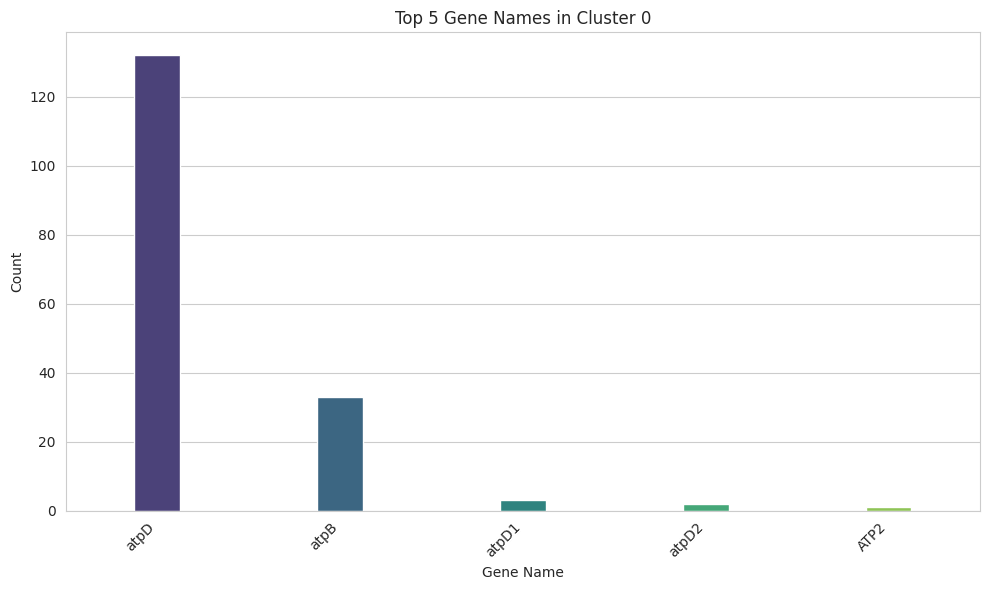

--------------------------------

Cluster 402:
  Top Protein Names:
    1. sp|P0A880|TRPB_SHIFL Tryptophan synthase beta chain (Count: 3)
    2. sp|B1JKS2|TRPB_YERPY Tryptophan synthase beta chain (Count: 2)
    3. sp|P0A2K1|TRPB_SALTY Tryptophan synthase beta chain (Count: 2)
    4. sp|Q8NWU2|TRPB_STAAW Tryptophan synthase beta chain (Count: 2)
    5. sp|Q88RP6|TRPB_PSEPK Tryptophan synthase beta chain (Count: 1)
--------------------------------
  Top Organism Species:
    1. Shigella flexneri (Count: 3)
    2. Yersinia pseudotuberculosis serotype O:3 (strain YPIII) (Count: 2)
    3. Salmonella typhimurium (strain LT2 / SGSC1412 / ATCC 700720) (Count: 2)
    4. Staphylococcus aureus (strain MW2) (Count: 2)
    5. Pseudomonas putida (strain ATCC 47054 / DSM 6125 / CFBP 8728 / NCIMB 11950 / KT2440) (Count: 1)
--------------------------------
  Top Gene Names:
    1. trpB (Count: 43)
    2. trpB1 (Count: 1)


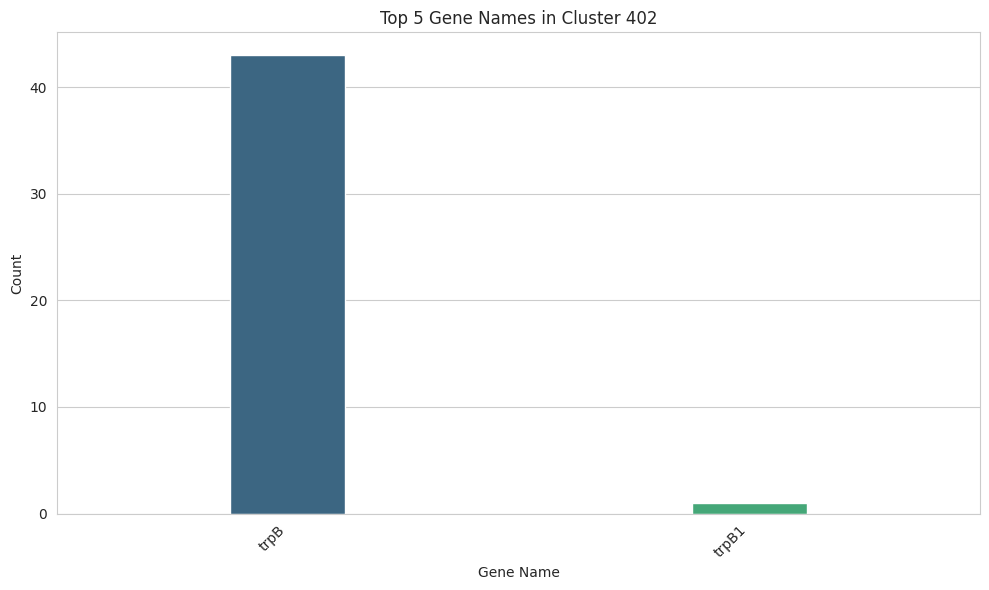

--------------------------------

Cluster 403:
  Top Protein Names:
    1. sp|Q3YZ56|HDA_SHISS DnaA regulatory inactivator Hda (Count: 4)
    2. sp|Q7CQ21|HDA_SALTY DnaA regulatory inactivator Hda (Count: 3)
    3. sp|B1JSF7|HDA_YERPY DnaA regulatory inactivator Hda (Count: 2)
    4. sp|B7LKE6|HDA_ESCF3 DnaA regulatory inactivator Hda (Count: 1)
    5. sp|A9MHP3|HDA_SALAR DnaA regulatory inactivator Hda (Count: 1)
--------------------------------
  Top Organism Species:
    1. Shigella sonnei (strain Ss046) (Count: 4)
    2. Salmonella typhimurium (strain LT2 / SGSC1412 / ATCC 700720) (Count: 3)
    3. Yersinia pseudotuberculosis serotype O:3 (strain YPIII) (Count: 2)
    4. Escherichia fergusonii (strain ATCC 35469 / DSM 13698 / CCUG 18766 / IAM 14443 / JCM 21226 / LMG 7866 / NBRC 102419 / NCTC 12128 / CDC 0568-73) (Count: 1)
    5. Salmonella arizonae (strain ATCC BAA-731 / CDC346-86 / RSK2980) (Count: 1)
--------------------------------
  Top Gene Names:
    1. hda (Count: 11)


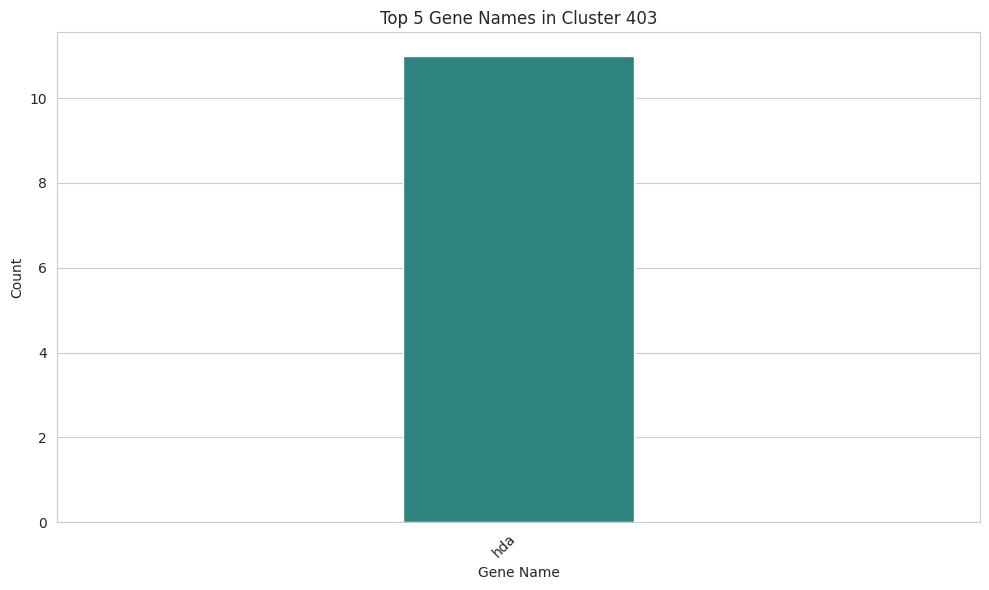

--------------------------------

Cluster 404:
  Top Protein Names:
    1. sp|Q3Z5Q7|ZAPD_SHISS Cell division protein ZapD (Count: 4)
    2. sp|B2U2A7|ZAPD_SHIB3 Cell division protein ZapD (Count: 2)
    3. sp|P67693|ZAPD_SALTY Cell division protein ZapD (Count: 2)
    4. sp|A9MQA5|ZAPD_SALAR Cell division protein ZapD (Count: 1)
    5. sp|B7NHK6|ZAPD_ECO7I Cell division protein ZapD (Count: 1)
--------------------------------
  Top Organism Species:
    1. Shigella sonnei (strain Ss046) (Count: 4)
    2. Shigella boydii serotype 18 (strain CDC 3083-94 / BS512) (Count: 2)
    3. Salmonella typhimurium (strain LT2 / SGSC1412 / ATCC 700720) (Count: 2)
    4. Salmonella arizonae (strain ATCC BAA-731 / CDC346-86 / RSK2980) (Count: 1)
    5. Escherichia coli O7:K1 (strain IAI39 / ExPEC) (Count: 1)
--------------------------------
  Top Gene Names:
    1. zapD (Count: 12)


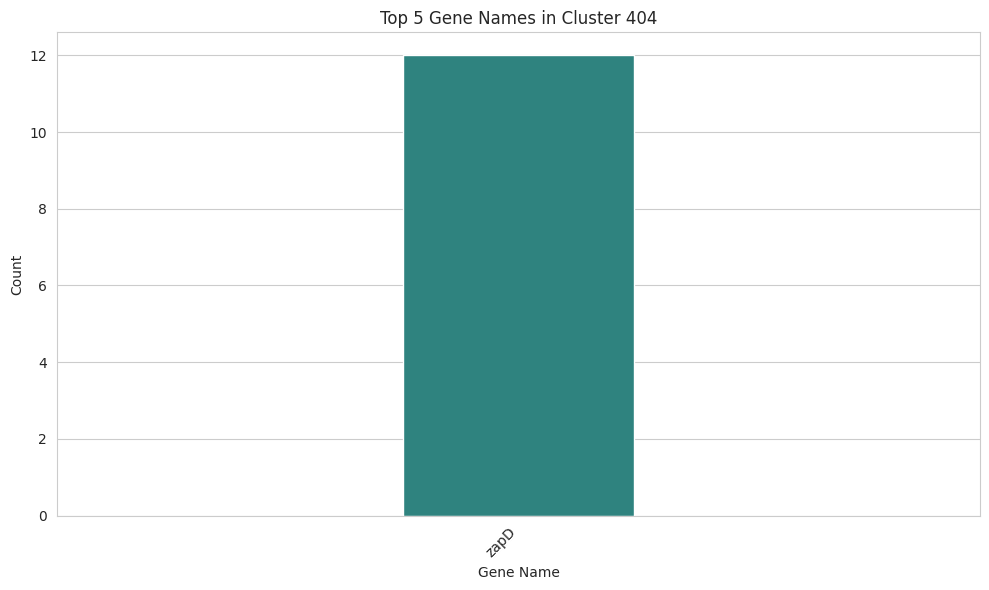

--------------------------------

Cluster 409:
  Top Protein Names:
    1. sp|Q32B63|DEF_SHIDS Peptide deformylase (Count: 7)
    2. sp|Q8ZLM7|DEF_SALTY Peptide deformylase (Count: 3)
    3. sp|A1KRE5|DEF_NEIMF Peptide deformylase (Count: 2)
    4. sp|B1JJH8|DEF_YERPY Peptide deformylase (Count: 2)
    5. sp|A9MN80|DEF_SALAR Peptide deformylase (Count: 1)
--------------------------------
  Top Organism Species:
    1. Shigella dysenteriae serotype 1 (strain Sd197) (Count: 7)
    2. Salmonella typhimurium (strain LT2 / SGSC1412 / ATCC 700720) (Count: 3)
    3. Neisseria meningitidis serogroup C / serotype 2a (strain ATCC 700532 / DSM 15464 / FAM18) (Count: 2)
    4. Yersinia pseudotuberculosis serotype O:3 (strain YPIII) (Count: 2)
    5. Salmonella arizonae (strain ATCC BAA-731 / CDC346-86 / RSK2980) (Count: 1)
--------------------------------
  Top Gene Names:
    1. def (Count: 20)


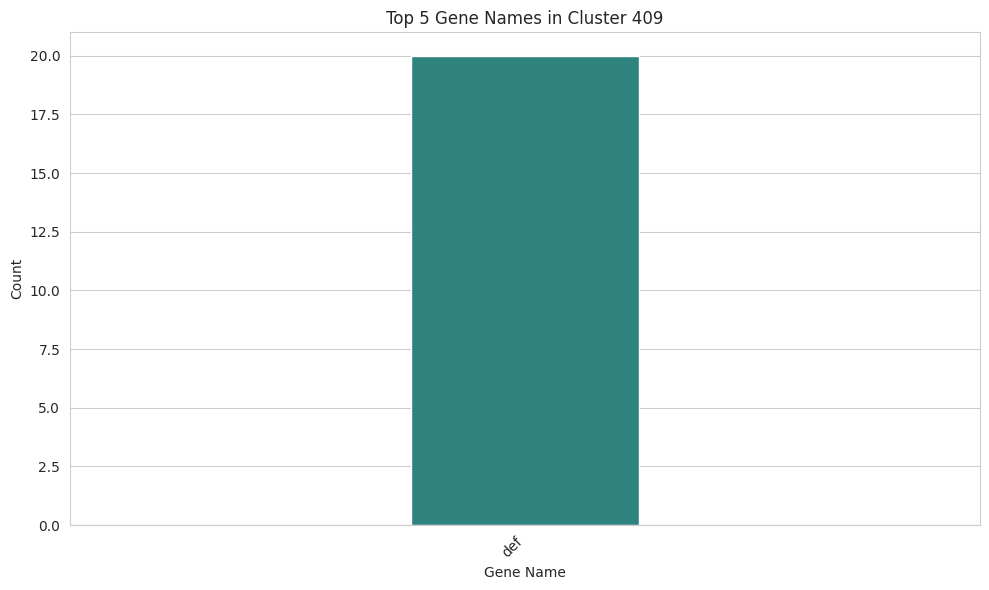

--------------------------------


In [ ]:
cluster_insights(top_5_stable_cluster_ids)

*Cluster 0*
* This cluster represents ATP synthase subunits, which form a highly conserved protein family.
* ATP synthase proteins have consistent length, structure, and motifs.

*Cluster 402*
* This cluster is a tryptophan biosynthesis enzyme family, again evolutionarily conserved.

*Cluster 403*
* It is part of the DNA replication control pathway in bacteria.
* This protein acts as a checkpoint regulator to ensure replication initiates properly and only once per cycle.

*Cluster 404*
* This is a small, well-conserved bacterial cell division protein.

*Cluster 409*
* Key enzyme in protein maturation (removes formyl group from initiator methionine).


**Conclusion**

These are all housekeeping genes, meaning they are:
* Essential for survival
* Conserved across many species
* Slow-evolving
* Structurally stable

### Cluster Insights for Top 5 Largest Clusters

Consolidated Cluster Insights:
--------------------------------

Cluster 0:
  Top Protein Names:
    1. sp|Q3YVN6|ATPB_SHISS ATP synthase subunit beta (Count: 4)
    2. sp|B1JRN2|ATPB_YERPY ATP synthase subunit beta (Count: 4)
    3. sp|P63680|ATPB_STAAW ATP synthase subunit beta (Count: 3)
    4. sp|Q7CPE2|ATPB_SALTY ATP synthase subunit beta (Count: 3)
    5. sp|C1CLK6|ATPB_STRZP ATP synthase subunit beta (Count: 2)
--------------------------------
  Top Organism Species:
    1. Shigella sonnei (strain Ss046) (Count: 4)
    2. Yersinia pseudotuberculosis serotype O:3 (strain YPIII) (Count: 4)
    3. Staphylococcus aureus (strain MW2) (Count: 3)
    4. Salmonella typhimurium (strain LT2 / SGSC1412 / ATCC 700720) (Count: 3)
    5. Streptococcus pneumoniae (strain P1031) (Count: 2)
--------------------------------
  Top Gene Names:
    1. atpD (Count: 132)
    2. atpB (Count: 33)
    3. atpD1 (Count: 3)
    4. atpD2 (Count: 2)
    5. ATP2 (Count: 1)


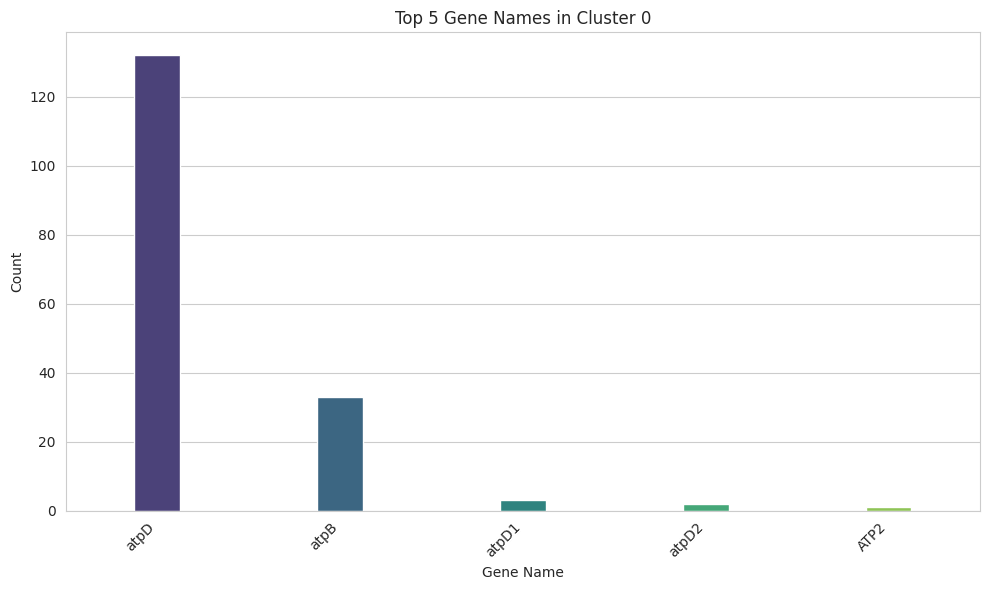

--------------------------------

Cluster 6:
  Top Protein Names:
    1. sp|Q3YUJ7|CH60_SHISS Chaperonin GroEL (Count: 5)
    2. sp|B1JMR1|CH60_YERPY Chaperonin GroEL (Count: 3)
    3. sp|P19421|CH60_COXBU Chaperonin GroEL (Count: 2)
    4. sp|P0A1D3|CH60_SALTY Chaperonin GroEL (Count: 2)
    5. sp|Q8PD23|CH60_XANCP Chaperonin GroEL (Count: 2)
--------------------------------
  Top Organism Species:
    1. Shigella sonnei (strain Ss046) (Count: 5)
    2. Yersinia pseudotuberculosis serotype O:3 (strain YPIII) (Count: 3)
    3. Coxiella burnetii (strain RSA 493 / Nine Mile phase I) (Count: 2)
    4. Francisella tularensis subsp. holarctica (strain OSU18) (Count: 2)
    5. Salmonella typhimurium (strain LT2 / SGSC1412 / ATCC 700720) (Count: 2)
--------------------------------
  Top Gene Names:
    1. groEL (Count: 116)
    2. groEL2 (Count: 25)
    3. groEL1 (Count: 20)
    4. Unknown (Count: 4)
    5. groEL3 (Count: 2)


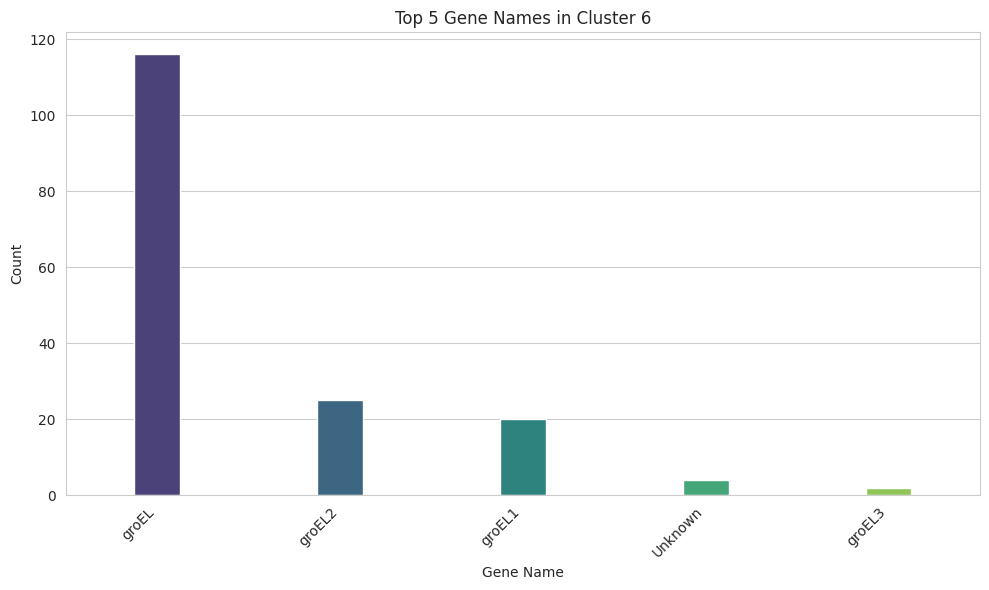

--------------------------------

Cluster 73:
  Top Protein Names:
    1. sp|B1JIW8|RL16_YERPY Large ribosomal subunit protein uL16 (Count: 4)
    2. sp|Q7CPL4|RL16_SALTY Large ribosomal subunit protein uL16 (Count: 3)
    3. sp|Q3YWU6|RL16_SHISS Large ribosomal subunit protein uL16 (Count: 3)
    4. sp|B5XJ43|RL16_STRPZ Large ribosomal subunit protein uL16 (Count: 3)
    5. sp|C1CP95|RL16_STRZT Large ribosomal subunit protein uL16 (Count: 2)
--------------------------------
  Top Organism Species:
    1. Yersinia pseudotuberculosis serotype O:3 (strain YPIII) (Count: 4)
    2. Salmonella typhimurium (strain LT2 / SGSC1412 / ATCC 700720) (Count: 3)
    3. Shigella sonnei (strain Ss046) (Count: 3)
    4. Streptococcus pyogenes serotype M49 (strain NZ131) (Count: 3)
    5. Streptococcus pneumoniae (strain Taiwan19F-14) (Count: 2)
--------------------------------
  Top Gene Names:
    1. rplP (Count: 147)
    2. rpl16 (Count: 20)
    3. RPL16 (Count: 1)


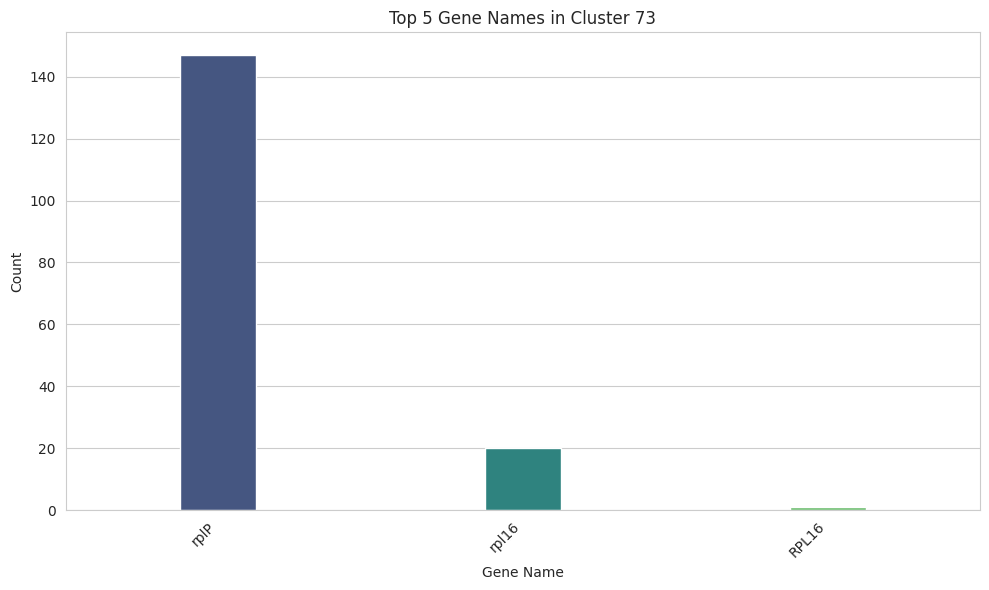

--------------------------------

Cluster 108:
  Top Protein Names:
    1. sp|Q7HFF9|CYB_SORUG Cytochrome b (Count: 2)
    2. sp|Q71FI9|CYB_VIVME Cytochrome b (Count: 1)
    3. sp|Q1XIP8|CYB_CROAE Cytochrome b (Count: 1)
    4. sp|Q5NUR7|CYB_PETEL Cytochrome b (Count: 1)
    5. sp|Q85IN8|CYB_EIRBA Cytochrome b (Count: 1)
--------------------------------
  Top Organism Species:
    1. Sorex ugyunak (Count: 2)
    2. Viverra megaspila (Count: 1)
    3. Crocidura attenuata (Count: 1)
    4. Petaurista elegans (Count: 1)
    5. Eira barbara (Count: 1)
--------------------------------
  Top Gene Names:
    1. MT-CYB (Count: 204)
    2. Mt-Cyb (Count: 1)


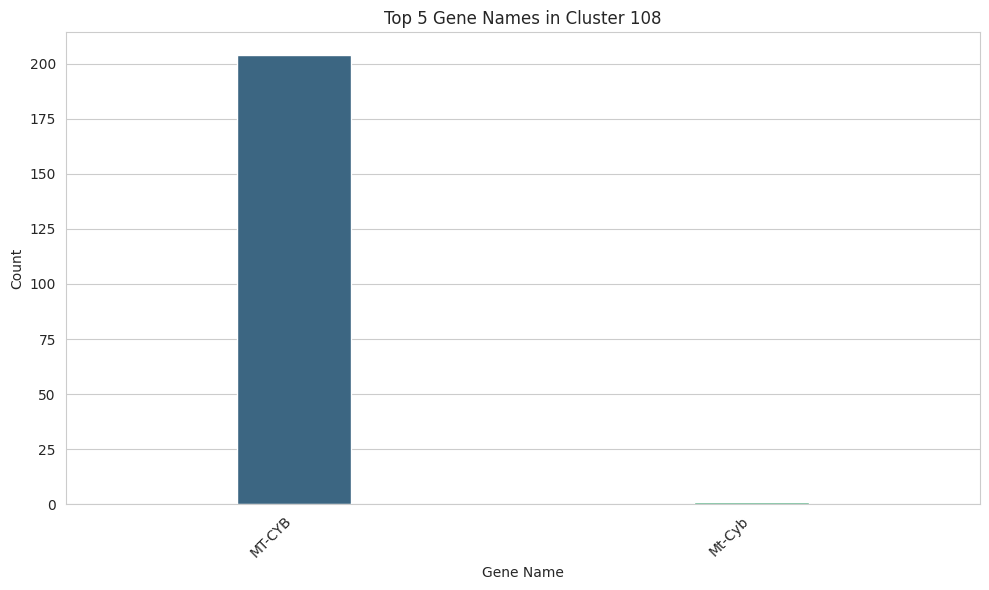

--------------------------------

Cluster 608:
  Top Protein Names:
    1. sp|P84219|HTF_RHYMA Hypertrehalosaemic hormone (Count: 8)
    2. sp|P85792|SK1_THEPT Sulfakinin-1 (Count: 5)
    3. sp|P04428|SK1_RHYMA Sulfakinin-1 (Count: 5)
    4. sp|P85855|HTF_SHELA Hypertrehalosaemic factor (Count: 3)
    5. sp|P85449|FAR2_LUCCU FMRFamide-2 (Count: 2)
--------------------------------
  Top Organism Species:
    1. Rhyparobia maderae (Count: 14)
    2. Therea petiveriana (Count: 5)
    3. Viola odorata (Count: 5)
    4. Sarcophaga bullata (Count: 5)
    5. Shelfordella lateralis (Count: 4)
--------------------------------
  Top Gene Names:
    1. Unknown (Count: 221)
    2. ENOD40 (Count: 3)
    3. SST (Count: 2)
    4. UL38 (Count: 1)
    5. ompH (Count: 1)


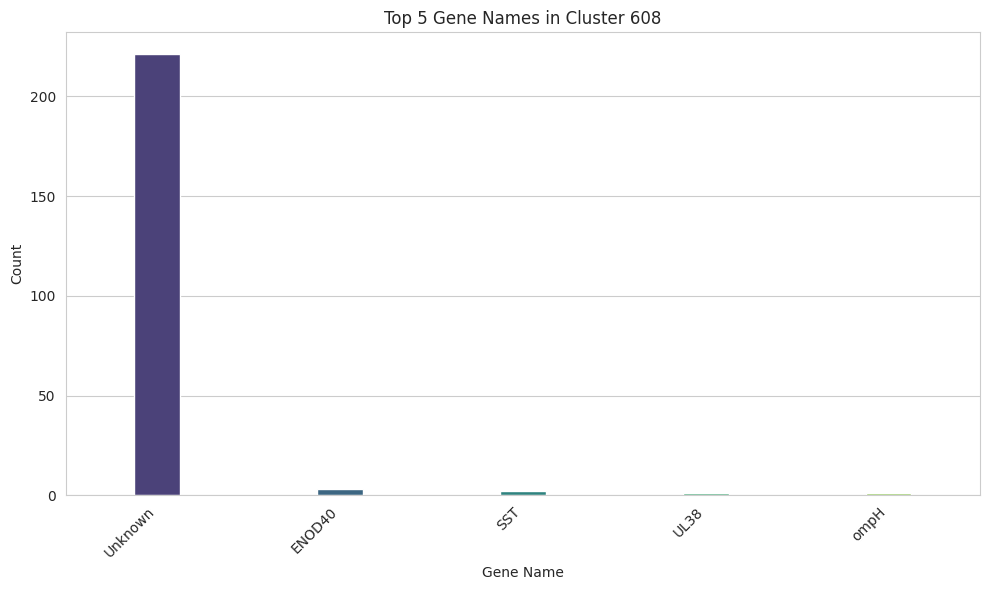

--------------------------------


In [ ]:
cluster_insights(top_5_largest_cluster_ids)

*Cluster 0*
* Cluster 0 appears in both most stable and largest clusters list.

*Cluster 6*
* GroEL proteins are highly conserved, large (~550 aa), and structurally constrained. These are essential for protein folding.

*Cluster 73*
* Predominently clusters the ribosomal proteins that are highly conserved across bacteria and chloroplast/mitochondrial ribosomes.

*Cluster 108*
* Cytochrome b is part of Complex III (cytochrome bc1) in mitochondrial electron transport.
* Universally conserved across eukaryotes.

*Cluster 608*
* Corresponds to unknown genes and a few known ones. Proteins with unknown genes could be hypothetical/truncated. One reason for grouping these proteins could be their similar sequence lengths.

### Cluster Insights for Top 5 Smallest Clusters

Consolidated Cluster Insights:
--------------------------------

Cluster 31:
  Top Protein Names:
    1. sp|A4JAR4|RS11_BURVG Small ribosomal subunit protein uS11 (Count: 5)
    2. sp|Q3BWW1|RS11_XANE5 Small ribosomal subunit protein uS11 (Count: 2)
    3. sp|A1KRJ7|RS11_NEIMF Small ribosomal subunit protein uS11 (Count: 1)
    4. sp|A1KB03|RS11_AZOSB Small ribosomal subunit protein uS11 (Count: 1)
    5. sp|C1DAU1|RS11_LARHH Small ribosomal subunit protein uS11 (Count: 1)
--------------------------------
  Top Organism Species:
    1. Burkholderia vietnamiensis (strain G4 / LMG 22486) (Count: 5)
    2. Xanthomonas euvesicatoria pv. vesicatoria (strain 85-10) (Count: 2)
    3. Neisseria meningitidis serogroup C / serotype 2a (strain ATCC 700532 / DSM 15464 / FAM18) (Count: 1)
    4. Azoarcus sp. (strain BH72) (Count: 1)
    5. Laribacter hongkongensis (strain HLHK9) (Count: 1)
--------------------------------
  Top Gene Names:
    1. rpsK (Count: 10)


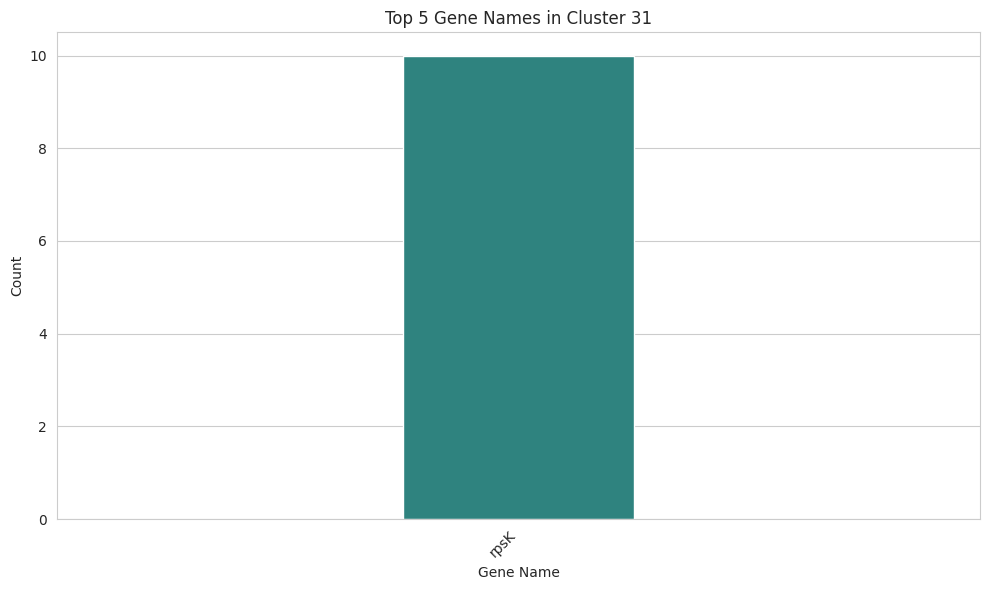

--------------------------------

Cluster 228:
  Top Protein Names:
    1. sp|Q8ZLL7|TUSD_SALTY Sulfurtransferase TusD (Count: 2)
    2. sp|Q6CZW0|TUSD_PECAS Sulfurtransferase TusD (Count: 1)
    3. sp|B5YTQ2|TUSD_ECO5E Sulfurtransferase TusD (Count: 1)
    4. sp|A4WFD8|TUSD_ENT38 Sulfurtransferase TusD (Count: 1)
    5. sp|B6I245|TUSD_ECOSE Sulfurtransferase TusD (Count: 1)
--------------------------------
  Top Organism Species:
    1. Salmonella typhimurium (strain LT2 / SGSC1412 / ATCC 700720) (Count: 2)
    2. Pectobacterium atrosepticum (strain SCRI 1043 / ATCC BAA-672) (Count: 1)
    3. Escherichia coli O157:H7 (strain EC4115 / EHEC) (Count: 1)
    4. Enterobacter sp. (strain 638) (Count: 1)
    5. Escherichia coli (strain SE11) (Count: 1)
--------------------------------
  Top Gene Names:
    1. tusD (Count: 10)


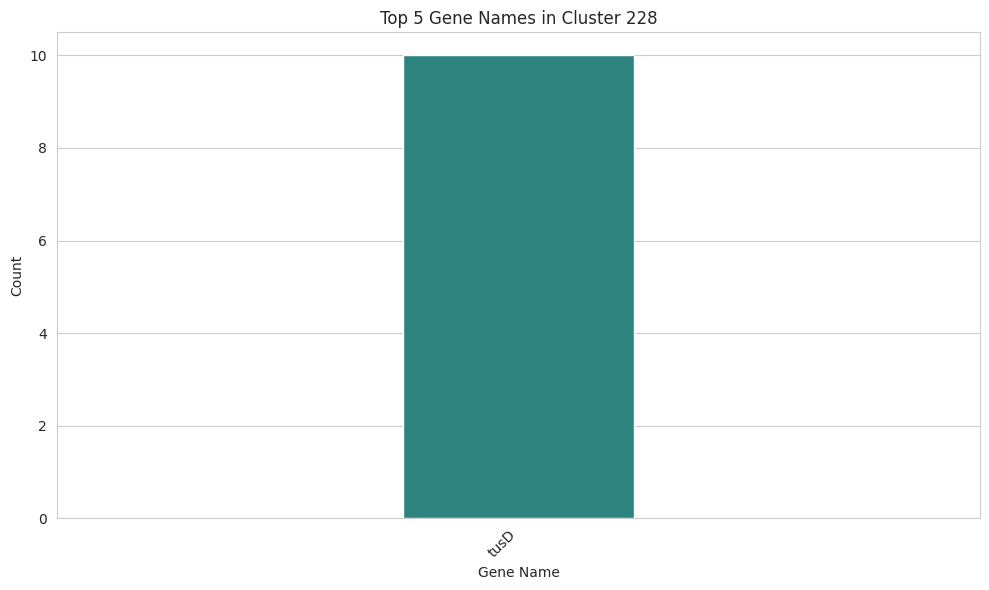

--------------------------------

Cluster 239:
  Top Protein Names:
    1. sp|Q1RDV7|YCAD_ECOUT Uncharacterized MFS-type transporter YcaD (Count: 3)
    2. sp|Q8ZNQ0|MDTD_SALTY Putative multidrug resistance protein MdtD (Count: 1)
    3. sp|B4TNI8|MDTD_SALSV Putative multidrug resistance protein MdtD (Count: 1)
    4. sp|B7NM77|YCAD_ECO7I Uncharacterized MFS-type transporter YcaD (Count: 1)
    5. sp|Q0TG13|MDTD_ECOL5 Putative multidrug resistance protein MdtD (Count: 1)
--------------------------------
  Top Organism Species:
    1. Escherichia coli (strain UTI89 / UPEC) (Count: 3)
    2. Salmonella typhimurium (strain LT2 / SGSC1412 / ATCC 700720) (Count: 1)
    3. Salmonella schwarzengrund (strain CVM19633) (Count: 1)
    4. Escherichia coli O7:K1 (strain IAI39 / ExPEC) (Count: 1)
    5. Escherichia coli O6:K15:H31 (strain 536 / UPEC) (Count: 1)
--------------------------------
  Top Gene Names:
    1. mdtD (Count: 5)
    2. ycaD (Count: 5)


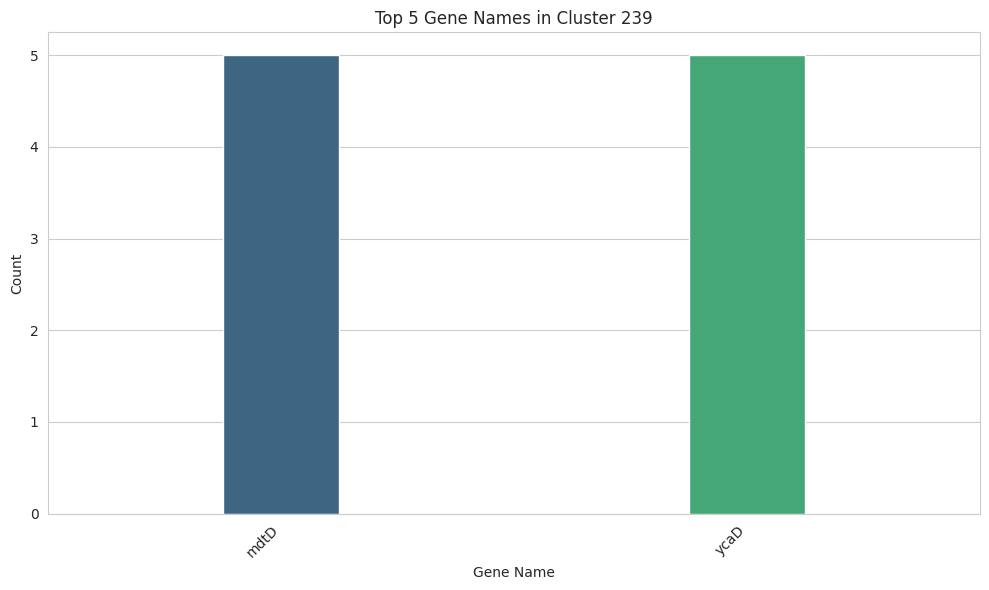

--------------------------------

Cluster 323:
  Top Protein Names:
    1. sp|Q11JI8|SYP_CHESB Proline--tRNA ligase (Count: 1)
    2. sp|B8GWT1|SYP_CAUVN Proline--tRNA ligase (Count: 1)
    3. sp|Q1MIJ6|SYP_RHIJ3 Proline--tRNA ligase (Count: 1)
    4. sp|A5EK68|SYP_BRASB Proline--tRNA ligase (Count: 1)
    5. sp|A5FX26|SYP_ACICJ Proline--tRNA ligase (Count: 1)
--------------------------------
  Top Organism Species:
    1. Chelativorans sp. (strain BNC1) (Count: 1)
    2. Caulobacter vibrioides (strain NA1000 / CB15N) (Count: 1)
    3. Rhizobium johnstonii (strain DSM 114642 / LMG 32736 / 3841) (Count: 1)
    4. Bradyrhizobium sp. (strain BTAi1 / ATCC BAA-1182) (Count: 1)
    5. Acidiphilium cryptum (strain JF-5) (Count: 1)
--------------------------------
  Top Gene Names:
    1. proS (Count: 10)


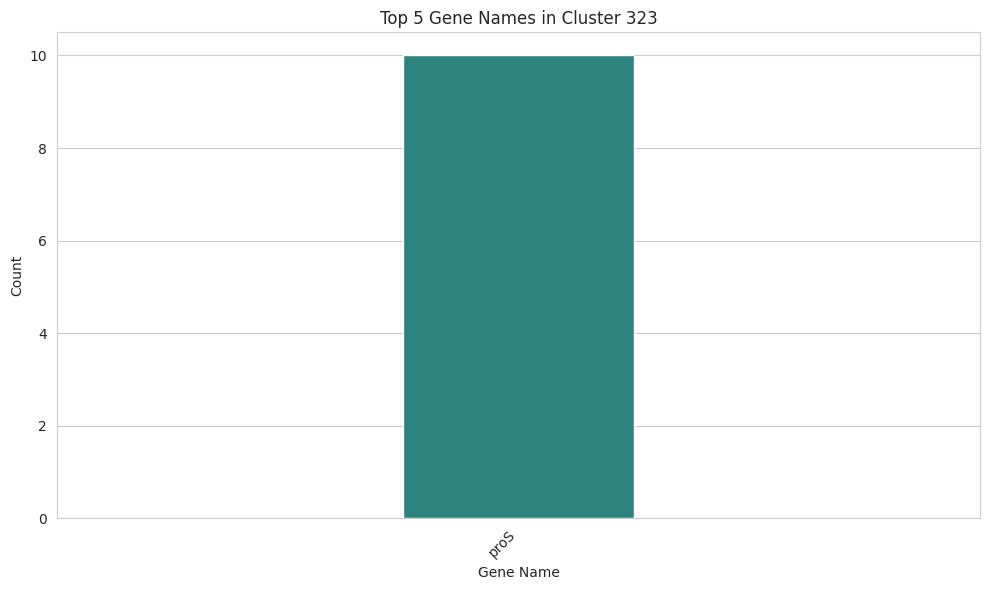

--------------------------------

Cluster 358:
  Top Protein Names:
    1. sp|P67387|UPPP_SHIFL Undecaprenyl-diphosphatase (Count: 2)
    2. sp|P60932|UPPP_ECOLI Undecaprenyl-diphosphatase (Count: 2)
    3. sp|B7UIW5|UPPP_ECO27 Undecaprenyl-diphosphatase (Count: 1)
    4. sp|B7NJS0|UPPP_ECO7I Undecaprenyl-diphosphatase (Count: 1)
    5. sp|P67388|UPPP_SALTY Undecaprenyl-diphosphatase (Count: 1)
--------------------------------
  Top Organism Species:
    1. Shigella flexneri (Count: 2)
    2. Escherichia coli (strain K12) (Count: 2)
    3. Escherichia coli O127:H6 (strain E2348/69 / EPEC) (Count: 1)
    4. Escherichia coli O7:K1 (strain IAI39 / ExPEC) (Count: 1)
    5. Salmonella typhimurium (strain LT2 / SGSC1412 / ATCC 700720) (Count: 1)
--------------------------------
  Top Gene Names:
    1. uppP (Count: 9)
    2. rnfA (Count: 1)


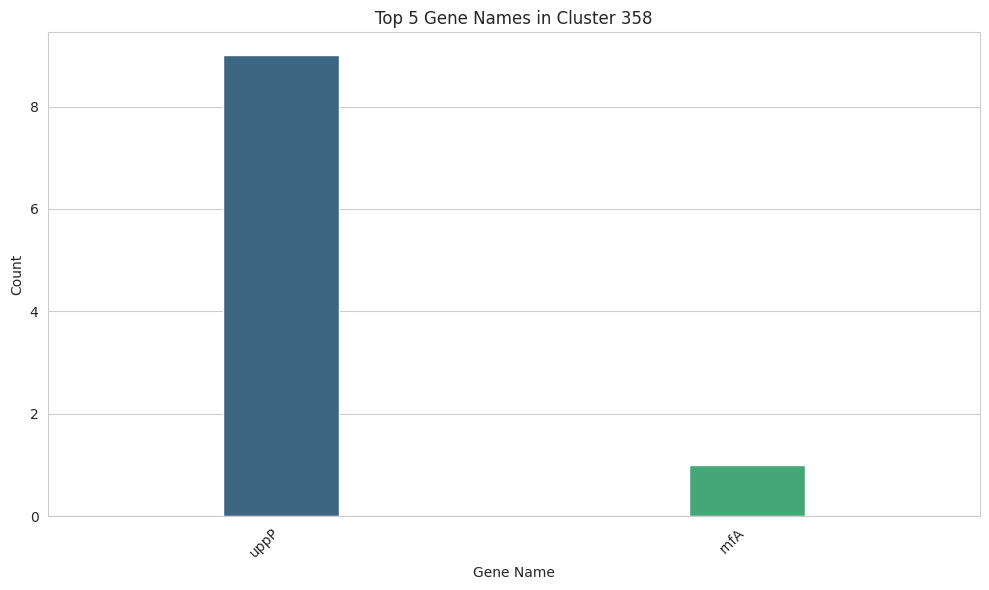

--------------------------------


In [ ]:
cluster_insights(top_5_smallest_cluster_ids)

Most of the small clusters are dominated by a single gene. This suggests very high sequence similarity. **Cluster 239** looks interesting as it contains equal number of proteins sharing two different genes. This could imply similar functionality of the corresponding genes.

## Multiple Sequence Alignment

Now, we perform MSA to identify shared motifs among protein clusters, allowing us to study the functional attributes of the corresponding proteins and obtain interesting results.

### Downloading MUSCLE to perform MSA

In [ ]:
# Update apt-get to ensure we get the latest package information
!apt-get update

# Install MUSCLE using apt-get
!apt-get install -y muscle

# Verify the installation by running MUSCLE with the --version flag
!muscle --version

print("MUSCLE installation complete and verified.")

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]           
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.6 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,201 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,842 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports

In [ ]:
# Extracts protein sequences from the specified cluster
def get_sequences_from_cluster(cluster_labels, selected_cluster_id):
    sequences_in_selected_cluster = [
        seq for i, seq in enumerate(sampled_sequences) if cluster_labels[i] == selected_cluster_id
    ]

    print(f"Extracted {len(sequences_in_selected_cluster)} sequences for cluster {selected_cluster_id}.")
    print("\nFirst 3 sequences in the selected cluster (first 50 characters):")
    for i, seq in enumerate(sequences_in_selected_cluster[:3]):
        print(f"Sequence {i+1}: {seq[:50]}...")

    return sequences_in_selected_cluster

In [ ]:
# Creates a FASTA file with protein sequences and feeds it to MUSCLE
# MUSLE extracts the representative protein sequence by aligning all
# sequences and determining the most dominant amino acid in each column.
# The results are written to an output FASTA file.
def multiple_sequence_alignment(cluster_id, sequences_in_selected_cluster):

    # Create the input FASTA file
    input_fasta_file = f"input_sequences_cluster_{cluster_id}.fasta"

    with open(input_fasta_file, 'w') as f:
        for i, seq in enumerate(sequences_in_selected_cluster):
            f.write(f'>Seq_{i+1}\n')
            f.write(f'{seq}\n')

    print(f"Successfully wrote {len(sequences_in_selected_cluster)} sequences to {input_fasta_file}")

    # Execute MUSCLE
    output_fasta_file = f"aligned_sequences_cluster_{cluster_id}.fasta"
    !muscle -in {input_fasta_file} -out {output_fasta_file}
    print(f"MUSCLE alignment performed and saved to {output_fasta_file}")

In [ ]:
# Extract meaningful information like the consensus sequence
# and conserved regions from the output FASTA file
def compute_conserved_regions(output_fasta_file):
    # 1. Use Bio.SeqIO.parse to read the aligned_sequences.fasta file.
    # 2. Store the aligned sequences in a list.
    aligned_records = list(SeqIO.parse(output_fasta_file, 'fasta'))
    aligned_sequences = [str(record.seq) for record in aligned_records]

    print(f"Loaded {len(aligned_sequences)} aligned sequences from {output_fasta_file}")

    # 3. Print the first few aligned sequences to observe the alignment.
    print("\nFirst 3 aligned sequences:")
    for i, seq in enumerate(aligned_sequences[:3]):
        print(f"Seq_{i+1}: {seq[:70]}...")

    if not aligned_sequences:
        print("No aligned sequences found.")
    else:
        alignment_length = len(aligned_sequences[0])
        print(f"\nAlignment length: {alignment_length}")

        # 4. Create a consensus sequence
        consensus_sequence_list = []
        for i in range(alignment_length):
            column = [seq[i] for seq in aligned_sequences]
            # Exclude gaps for consensus, but include for conservation check below
            non_gap_column = [aa for aa in column if aa != '-']
            if non_gap_column:
                aa_counts = Counter(non_gap_column)
                # Sort by count (descending), then by amino acid (ascending alphabetically) for tie-breaking
                most_common_aa = sorted(aa_counts.items(), key=lambda x: (-x[1], x[0]))[0][0]
                consensus_sequence_list.append(most_common_aa)
            else:
                # If all are gaps, the consensus for this position is a gap
                consensus_sequence_list.append('-')

        consensus_sequence = "".join(consensus_sequence_list)
        print(f"\nConsensus Sequence (length {len(consensus_sequence)}):\n{consensus_sequence}")

        # 5. Identify 100% conserved regions
        conserved_regions = []
        current_conserved_start = -1

        for i in range(alignment_length):
            column = [seq[i] for seq in aligned_sequences]
            # Check if all characters at the current position are identical
            if len(set(column)) == 1:
                # If it's the start of a new conserved region
                if current_conserved_start == -1:
                    current_conserved_start = i
            else:
                # If a conserved region just ended
                if current_conserved_start != -1:
                    conserved_regions.append((current_conserved_start, i - 1))
                    current_conserved_start = -1

        # Check if a conserved region extends to the end of the sequence
        if current_conserved_start != -1:
            conserved_regions.append((current_conserved_start, alignment_length - 1))

        print("\nIdentified 100% Conserved Regions (Start and End positions are 0-indexed):")
        if conserved_regions:
            for start, end in conserved_regions:
                region_sequence = aligned_sequences[0][start : end + 1] # Use any sequence from the alignment
                print(f"  Positions {start}-{end}: {region_sequence}")
        else:
            print("  No 100% conserved regions found.")

### Results for Stable Clusters

#### Cluster 0

In [ ]:
# Get protein sequences for Cluster 0 (most stable and largest cluster)
sequences_in_cluster_0 = get_sequences_from_cluster(cluster_labels, 0)

Extracted 173 sequences for cluster 0.

First 3 sequences in the selected cluster (first 50 characters):
Sequence 1: MEGKIIQVLGPVVDVEFESYLPAIFEALDINFEVNGVQKSLVLEVAAHLG...
Sequence 2: MSNNIGKVVQVIGPVVDIKFANDELPNIFNAIHIKMDDGKILVCEVEQHV...
Sequence 3: MATGKIVQVIGAVVDVEFPQDAVPRVYDALEVQNGNERLVLEVQQQLGGG...


In [ ]:
# Execute multiple sequence alignment for cluster 0
multiple_sequence_alignment(0, sequences_in_cluster_0)

Successfully wrote 173 sequences to input_sequences_cluster_0.fasta

MUSCLE v3.8.1551 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

input_sequences_cluster_0 173 seqs, lengths min 158, max 531, avg 474
00:00:00    16 MB(-1%)  Iter   1  100.00%  K-mer dist pass 1
00:00:00    16 MB(-1%)  Iter   1  100.00%  K-mer dist pass 2
00:00:01    70 MB(-5%)  Iter   1  100.00%  Align node       
00:00:01    70 MB(-5%)  Iter   1  100.00%  Root alignment
00:00:02    70 MB(-5%)  Iter   2  100.00%  Refine tree   
00:00:02    70 MB(-5%)  Iter   2  100.00%  Root alignment
00:00:02    70 MB(-5%)  Iter   2  100.00%  Root alignment
00:00:03    70 MB(-5%)  Iter   3  100.00%  Refine biparts
00:00:05    70 MB(-5%)  Iter   4  100.00%  Refine biparts
00:00:05    70 MB(-5%)  Iter   5  100.00%  Refine biparts
00:00:05    70 MB(-5%)  Iter   5  100.00%  Refine biparts
00:00:06    70 MB(-5%)  Iter   6  100.00%

In [ ]:
# Get statistics for aligned sequences
compute_conserved_regions("aligned_sequences_cluster_0.fasta")

Loaded 173 aligned sequences from aligned_sequences_cluster_0.fasta

First 3 aligned sequences:
Seq_1: ----------------------------------------------MADASHDTQVSGHLTAIHGSVVDV...
Seq_2: --------------------------------------------------MSTATATGRVTQVIGSTFDA...
Seq_3: ------------------------------------------------------MANGKVIQVIGSVVDV...

Alignment length: 599

Consensus Sequence (length 599):
MVKAVMAKAATPKTTAAAEAKPAAKAPAKKAAPMRIAANPTTSTTGPAVSTLEEMNTGKIVQVIGPVVDVEFAPPGKELMLPSVKIYNALEVKGRDTGGQKINEAECNGLTLEVQQHLGDNVVRTIAMGSTDGLVRGMEVIDTGAPISVPVGKATLGRIFNVLGEPIDLELGKPVGTEQSDDVERWPIHRSAPAFEELSTKTEILETGIKVIDLLAPYAKGGKIGLFGGAGVGKTVLIMELINNIAKEHGGYSVFAGVGERTREGNDLYHEMKESGVINEKNIAEESMEGGGWDLSKVDKNELKKSKVALVYGQMNEPPGARMRVALTGLTMAEYFRDGVGEGEKDENGKGQDVLLFIDNIFRFTQAGSEVSALLGRMPSAVGYQPTLATEMGVLQERITSTKKGSITSIQAVYVPADDLTDPAPATTFAHLDATTVLSRQIASLGIYPAVDPLDSTSRMLDPLIVGEEHYEVARGVQQTLQRYKELQDIIAILGMDELSEEDKLTVARARKIQRFLSQPFFVAEVFTGSPGKYVPLKETIRGFKGILEGEYDHLPEQAFYMVGSIDEAIEKAKKLEAEVSESKLKKLLEKARVAQASS

Ide

#### MSA Interpretation for Cluster 0

* The consensus contains a *P-loop / Walker A–type (GGAGVGKTV)* ATP-binding signature and the *DELSEED motif (DELSEEDK)* — together these are hallmark features of the F₁ ATP synthase β subunit (AtpD / ATP synthase beta).

* This consensus very likely represents the ATP synthase F1 β subunit — a core, essential, ATP-binding enzyme.

#### Drug Design Implications for P-loop / Walker A–type

* *ATP-competitive inhibitors:* Small molecules that bind the nucleotide pocket can block ATP binding/hydrolysis.

* *Risks:* The P-loop is highly conserved across bacteria and eukaryotes (mitochondria). Direct ATP-pocket inhibitors often suffer selectivity/toxicity problems if human homologs share the pocket.

#### Drug Design Implications for DELSEED motif

* *Allosteric inhibition:* Targeting DELSEED or its interaction surfaces can disrupt ATP-synthase conformational cycling without directly competing with ATP.

* *Higher selectivity potential:* Interface or conformational inhibitors can be more selective if the interaction surface contains species-specific differences.

#### Cluster 402

In [ ]:
# Get protein sequences for Cluster 402 (most stable and largest cluster)
sequences_in_cluster_402 = get_sequences_from_cluster(cluster_labels, 402)

Extracted 44 sequences for cluster 402.

First 3 sequences in the selected cluster (first 50 characters):
Sequence 1: MTTLLNPYFGEFGGMYVPQILMPALRQLEEAFVSAQKDPEFQAQFNDLLK...
Sequence 2: MAKLNAYFGEYGGQYVPQILVPALDQLEQAFIDAQEDPDFRAEFMSLLQE...
Sequence 3: MNKPVAPNSYKTGPDEEGMFGIFGGRFVAETLMPLILELQQAYETARNDP...


In [ ]:
# Execute multiple sequence alignment for cluster 402
multiple_sequence_alignment(402, sequences_in_cluster_402)

Successfully wrote 44 sequences to input_sequences_cluster_402.fasta

MUSCLE v3.8.1551 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

input_sequences_cluster_402 44 seqs, lengths min 391, max 422, avg 400
00:00:00    16 MB(-1%)  Iter   1  100.00%  K-mer dist pass 1
00:00:00    16 MB(-1%)  Iter   1  100.00%  K-mer dist pass 2
00:00:01    29 MB(-2%)  Iter   1  100.00%  Align node       
00:00:01    29 MB(-2%)  Iter   1  100.00%  Root alignment
00:00:01    29 MB(-2%)  Iter   2  100.00%  Refine tree   
00:00:01    29 MB(-2%)  Iter   2  100.00%  Root alignment
00:00:01    29 MB(-2%)  Iter   2  100.00%  Root alignment
00:00:01    29 MB(-2%)  Iter   3  100.00%  Refine biparts
00:00:01    29 MB(-2%)  Iter   4  100.00%  Refine biparts
00:00:01    29 MB(-2%)  Iter   5  100.00%  Refine biparts
00:00:01    29 MB(-2%)  Iter   6  100.00%  Refine biparts
00:00:01    29 MB(-2%)  Iter   7  100.0

In [ ]:
# Get statistics for aligned sequences
compute_conserved_regions("aligned_sequences_cluster_402.fasta")

Loaded 44 aligned sequences from aligned_sequences_cluster_402.fasta

First 3 aligned sequences:
Seq_1: --------MKTYQVNKEGYYGEFGGAYIPEILHRCVEELQNAYSKVLESEGFKQEFHQLLRDYVGRPSPL...
Seq_2: ---MTEKENLGGSTLLPAYFGEFGGQFVAESLLPALDQLEKAFVDATNSPEFREELGGYLRDYLGRPTPL...
Seq_3: ------------MNQLDTKFGEFGGMYVPELLIPALDQLEKAFLDAKEDPSFNEEFLSLLKDYAGRPTAM...

Alignment length: 449

Consensus Sequence (length 449):
MNKPVEPNSYYMMTDLNGYFGEFGGMYVPEILMPALKQLEEAFVSAQEDPEFQAEFNDLLKNYAGRPTALTLARNLTLAGKGTGRPDGTGTKIYLKREDLLHGGAHKTNQVLGQALLAKRMGKTRIIAETGAGQHGVATALACALLGLKCRVYMGAKDVERQSPNVFRMKLMGAEVIPVHSGSATLKDACNEALRDWSGNYEDTHYLLGTAAGPHPYPTIVREFQRMIGEETKAQILEKEAEGRLAAEHPDAVIACVGGGSNAIGMFADFIDEESVRLIGVEPAGKGIETGMEHGAPLKHGRPAGILHGMKAPLMQDEDGQIEESYSISAGLDFPSVGPQHAYLNDIGRADYVSITDDEALEAFQTLCRHEGIIPALESSHALAYALKMAREMPEKEQNLILVVNLSGRGDKDIFTVHDILKVDFYDRPSARGEIQDGAEAAESGNDNN

Identified 100% Conserved Regions (Start and End positions are 0-indexed):
  Positions 20-20: G
  Positions 23-24: GG
  Positions 64-65: GR
  Positions 

#### MSA Interpretation for Cluster 402

* *PLP-Binding Lysine (HGGAHKT)*, *Glycine-rich loop (GGGSNAIGM)*, *Catalytic Loop (NQVLGQAL)*, and *COMM Domain (VIGVEPAGKGIETGMEHGA)* are the prominent motifs.

#### Drug Design Implications

* TrpB is a validated antimicrobial target. Humans lack the tryptophan biosynthesis pathway. Many bacteria require Trp biosynthesis for survival, virulence, or colonization. Therefore, inhibiting TrpB selectively kills bacteria without affecting the host.

*Example:* TrpB is considered a drug target for latent TB.

### Results for Largest Clusters

#### Cluster 6

In [ ]:
# Get protein sequences for Cluster 6
sequences_in_cluster_6 = get_sequences_from_cluster(cluster_labels, 6)

Extracted 177 sequences for cluster 6.

First 3 sequences in the selected cluster (first 50 characters):
Sequence 1: MAAKDVKFGNDARIKMLEGVNVLADAVKVTLGPKGRNVVLDKSFGAPTIT...
Sequence 2: MHRFASGLASKARLARKGANQIASRSSWSRNYAAKDVKFGVEARGLMLKG...
Sequence 3: MAKDIEYNETARRKLLEGVNKLANAVKVTLGPKGRNVVIDKKFGAPTITK...


In [ ]:
# Execute multiple sequence alignment for cluster 6
multiple_sequence_alignment(6, sequences_in_cluster_6)

Successfully wrote 177 sequences to input_sequences_cluster_6.fasta

MUSCLE v3.8.1551 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

input_sequences_cluster_6 177 seqs, lengths min 495, max 595, avg 546
00:00:00    16 MB(-1%)  Iter   1  100.00%  K-mer dist pass 1
00:00:00    16 MB(-1%)  Iter   1  100.00%  K-mer dist pass 2
00:00:01    78 MB(-5%)  Iter   1  100.00%  Align node       
00:00:01    78 MB(-5%)  Iter   1  100.00%  Root alignment
00:00:02    78 MB(-5%)  Iter   2  100.00%  Refine tree   
00:00:02    78 MB(-5%)  Iter   2  100.00%  Root alignment
00:00:02    78 MB(-5%)  Iter   2  100.00%  Root alignment
00:00:02    78 MB(-5%)  Iter   3  100.00%  Refine biparts
00:00:03    78 MB(-5%)  Iter   4  100.00%  Refine biparts
00:00:03    78 MB(-5%)  Iter   5  100.00%  Refine biparts
00:00:03    78 MB(-5%)  Iter   6  100.00%  Refine biparts
00:00:03    78 MB(-5%)  Iter   7  100.00%

In [ ]:
# Get statistics for aligned sequences
compute_conserved_regions("aligned_sequences_cluster_6.fasta")

Loaded 177 aligned sequences from aligned_sequences_cluster_6.fasta

First 3 aligned sequences:
Seq_1: ------------------------------------------------MANMVVTGEQ--LDKSIREVVR...
Seq_2: -------------------------------MLRVNSKSSIKTFVRHLSHKELKFGVE--GRAALLKGVN...
Seq_3: --------------------MFKMYRSPHITRNSFKYLKATNINSCRFYAKEVRFGPD--VRSLMLQGVD...

Alignment length: 696

Consensus Sequence (length 696):
MASTFSATTSSCNLMSMAAASSAMAAKARVARNARNQIGSRLSWSRNMAAKDIKFGEDGSARRKMLRGVNILADAVKVTLGPKGRNVVLEKSFGAPTITKDGVSVAKEIELEDKFENMGAQLVKEVASKTNDVARCLGDGTTTATVLAQAIVREGLKAVAAGMNPMDLKRGIDKAVAAAVEELAKKLSKPVSDSKEIAQVGTISANSDEEIGKLIAEAMEKVGKEGVITVEEGKGLETFELEVVEGMQFDRGYLSPYFVTNPEKMEAELEDPYILLTDKKISNIKQDLLPVLEAVAKANSGKKPLLIIAEDVEGEALATLVVNKLRGILKVAAVKAPGFGDRRKAMLEDIAILTGGKTVISEEGLGLKLEKATDLEDLGQAKRVVITKDNTTIVDSGAGDSDIKAAIEARVAQIRAQIEETHTSDYDREKLQERLAKLAGGVAVIKVGAATEVEMKEKKDRVEDALHATRAAVEEGIVPGGGVALIRAAAKALALNLGLDLIEKGENLNGDQNTGINIVLRALEAPLRQIAENAGTEEGSVVVEKVRTLQKEGEGDNYGYNAATGEYGEDMIEAGIIDPTKVTRSALQNAASVAGLLLTTEAMV

#### MSA Interpretation for Cluster 6
The conserved *GDGTT* motif (positions 137–141) within the central core, along with surrounding glycine residues, matches the phosphate-binding loop (P-loop) signature typical of ATP/GTP-dependent enzymes.

The C-terminal glycine/alanine-rich tail (residues ~550–696) suggests an intrinsically disordered or flexible region, whereas the central enzymatic domain shows strong evolutionary conservation indicative of a constrained catalytic fold.

#### Drug Design Implications

It is a potential antibiotic target —

* Essential catalytic core: Inhibiting nucleotide binding in the GDGTT-containing P-loop could disrupt ATP/GTP-dependent activity.
* Broad conservation across 177 sequences implies functional importance and low mutational tolerance.

*Example*: Small molecules targeting conserved P-loop pockets in bacterial ATP-dependent enzymes demonstrate druggability.

#### Cluster 608

In [ ]:
# Get protein sequences for Cluster 608
sequences_in_cluster_608 = get_sequences_from_cluster(cluster_labels, 608)

Extracted 249 sequences for cluster 608.

First 3 sequences in the selected cluster (first 50 characters):
Sequence 1: QLTFTPGWGY...
Sequence 2: GIPCGESCVWIPCISSAIGCSCKSKVCYRN...
Sequence 3: GIPCGESCVWIPCISSAIGCSCKSKVCYRN...


In [ ]:
# Execute multiple sequence alignment for cluster 608
multiple_sequence_alignment(608, sequences_in_cluster_608)

Successfully wrote 249 sequences to input_sequences_cluster_608.fasta

MUSCLE v3.8.1551 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

input_sequences_cluster_608 249 seqs, lengths min 4, max 267, avg 24
00:00:00    16 MB(-1%)  Iter   1  100.00%  K-mer dist pass 1
00:00:00    16 MB(-1%)  Iter   1  100.00%  K-mer dist pass 2
00:00:00    32 MB(-2%)  Iter   1  100.00%  Align node       
00:00:00    32 MB(-2%)  Iter   1  100.00%  Root alignment
00:00:00    35 MB(-2%)  Iter   2  100.00%  Refine tree   
00:00:00    35 MB(-2%)  Iter   2  100.00%  Root alignment
00:00:00    35 MB(-2%)  Iter   2  100.00%  Root alignment
00:00:04    35 MB(-2%)  Iter   3  100.00%  Refine biparts
00:00:07    35 MB(-2%)  Iter   4  100.00%  Refine biparts
00:00:07    35 MB(-2%)  Iter   5  100.00%  Refine biparts
00:00:07    35 MB(-2%)  Iter   5  100.00%  Refine biparts
MUSCLE alignment performed and saved to 

In [ ]:
# Get statistics for aligned sequences
compute_conserved_regions("aligned_sequences_cluster_608.fasta")

Loaded 249 aligned sequences from aligned_sequences_cluster_608.fasta

First 3 aligned sequences:
Seq_1: ----------------------------------------------------------------------...
Seq_2: ----------------------------------------------------------------------...
Seq_3: ----------------------------------------------------------------------...

Alignment length: 267

Consensus Sequence (length 267):
MAAAAAALALSSFAFAGQALALSPSAIEGNGNGRIRKRAAKAKPAPSGSPWXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXSXXXXXXXTSXKGXXXXXXXXXXXXECCCGICCGCCCCGEECCQGXFGVSCCDNGFCRFKWCVCYRNRGCCCKYRCAGGPLCCVKDCLCPGGICDCLGLACDPEAFAELKVKEIKNGRLAMFSMFGFFVQAIVTGKGPLENLADHCADPVNNNAWAFATNFVPGK

Identified 100% Conserved Regions (Start and End positions are 0-indexed):
  No 100% conserved regions found.


#### MSA Interpretation for Cluster 608

The sequence is highly variable with many X positions, but cysteine-rich regions in the middle and C-terminal suggest structural or disulfide-bonded motifs. The N-terminal alanine/leucine repeats may form a signal or membrane-targeting region.

#### Drug Design Implications

* Conserved cysteine motifs could be targeted to disrupt structure or function.
* High variability elsewhere makes broad targeting difficult.

### Results for Smallest Clusters

#### Cluster 31

In [ ]:
# Get protein sequences for Cluster 31 (smallest cluster)
sequences_in_cluster_31 = get_sequences_from_cluster(cluster_labels, 31)

Extracted 10 sequences for cluster 31.

First 3 sequences in the selected cluster (first 50 characters):
Sequence 1: MAKPAEKKTKKKIKRVITDGVAHVHASFNNTIVTITDRQGNALSWATSGG...
Sequence 2: MAKASNTAAQRVRKKVKKNVAEGVVHVHASFNNTIITITDRQGNALAWAT...
Sequence 3: MAKPAEKKTKKKIKRVITDGVAHVHASFNNTIVTITDRQGNALSWATSGG...


In [ ]:
# Execute multiple sequence alignment for cluster 31
multiple_sequence_alignment(31, sequences_in_cluster_31)

Successfully wrote 10 sequences to input_sequences_cluster_31.fasta

MUSCLE v3.8.1551 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

input_sequences_cluster_31 10 seqs, lengths min 129, max 133, avg 131
00:00:00    16 MB(-1%)  Iter   1  100.00%  K-mer dist pass 1
00:00:00    16 MB(-1%)  Iter   1  100.00%  K-mer dist pass 2
00:00:00    18 MB(-1%)  Iter   1  100.00%  Align node       
00:00:00    18 MB(-1%)  Iter   1  100.00%  Root alignment
00:00:00    18 MB(-1%)  Iter   2  100.00%  Root alignment
00:00:00    18 MB(-1%)  Iter   3  100.00%  Refine biparts
00:00:00    18 MB(-1%)  Iter   4  100.00%  Refine biparts
00:00:00    18 MB(-1%)  Iter   5  100.00%  Refine biparts
00:00:00    18 MB(-1%)  Iter   6  100.00%  Refine biparts
00:00:00    18 MB(-1%)  Iter   7  100.00%  Refine biparts
00:00:00    18 MB(-1%)  Iter   8  100.00%  Refine biparts
MUSCLE alignment performed and saved to a

In [ ]:
# Get statistics for aligned sequences
compute_conserved_regions("aligned_sequences_cluster_31.fasta")

Loaded 10 aligned sequences from aligned_sequences_cluster_31.fasta

First 3 aligned sequences:
Seq_1: MAKP---AEKKTKKKIKRVITDGVAHVHASFNNTIVTITDRQGNALSWATSGGAGFRGSRKSTPFAAQVA...
Seq_2: MAKP---AEKKTKKKIKRVITDGVAHVHASFNNTIVTITDRQGNALSWATSGGAGFRGSRKSTPFAAQVA...
Seq_3: MAKASNTAAQRVRKKVKKNVAEGVVHVHASFNNTIITITDRQGNALAWATSGGQGFKGSRKSTPFAAQVA...

Alignment length: 133

Consensus Sequence (length 133):
MAKASNTAAQRVRKKVKKNVAEGVVHVHASFNNTIITITDRQGNALAWATSGGAGFKGSRKSTPFAAQVAAESAGRVAMEYGVKNLEVRIKGPGPGRESAVRALHGLGIKITAISDVTPIPHNGCRPPKKRRI

Identified 100% Conserved Regions (Start and End positions are 0-indexed):
  Positions 0-2: MAK
  Positions 13-14: KK
  Positions 22-22: G
  Positions 25-34: HVHASFNNTI
  Positions 36-45: TITDRQGNAL
  Positions 47-52: WATSGG
  Positions 54-55: GF
  Positions 57-67: GSRKSTPFAAQ
  Positions 69-71: AAE
  Positions 73-74: AG
  Positions 77-77: A
  Positions 81-83: GVK
  Positions 85-96: LEVRIKGPGPGR
  Positions 98-98: S
  Positions 100-101: VR
  Positions 103-103: L
  

#### MSA Interpretation for Cluster 31

Several conserved motifs are apparent:

* MAK at the N-terminus may indicate a start or signal sequence.
* *HVHASFNNTI* and *TITDRQGNAL* are highly conserved, suggesting essential functional or structural regions.
* *WATSGG*, *GSRKSTPFAAQ*, *LEVRIKGPGPGR*, and *PHNGCRPPKRR* motifs are conserved, possibly forming active sites or protein–protein interaction surfaces.

#### Drug Design Implications

* Conserved motifs are critical for protein function.
* Targeting these motifs could disrupt activity or interactions.

*Example*: Small molecules or peptides designed against *GPGPG* or *CRPPK* motifs may inhibit protein function.

#### Cluster 239

In [ ]:
# Get protein sequences for Cluster 239 (smallest cluster)
sequences_in_cluster_239 = get_sequences_from_cluster(cluster_labels, 239)

Extracted 10 sequences for cluster 239.

First 3 sequences in the selected cluster (first 50 characters):
Sequence 1: MTELPDNTRWQLWIVAFGFFMQSLDTTIVNTALPSMAKSLGESPLHMHMV...
Sequence 2: MTELPDNTRWQLWIVAFGFFMQSLDTTIVNTALPSMAKSLGESPLHMHMV...
Sequence 3: MSTYTRPVMLLLSGLLLLTLAIAVLNTLVPLWLAQEHMSTWQVGVVSSSY...


In [ ]:
# Execute multiple sequence alignment for cluster 239
multiple_sequence_alignment(239, sequences_in_cluster_239)

Successfully wrote 10 sequences to input_sequences_cluster_239.fasta

MUSCLE v3.8.1551 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

input_sequences_cluster_239 10 seqs, lengths min 382, max 471, avg 426
00:00:00    16 MB(-1%)  Iter   1  100.00%  K-mer dist pass 1
00:00:00    16 MB(-1%)  Iter   1  100.00%  K-mer dist pass 2
00:00:00    20 MB(-1%)  Iter   1  100.00%  Align node       
00:00:00    20 MB(-1%)  Iter   1  100.00%  Root alignment
00:00:00    20 MB(-1%)  Iter   2  100.00%  Refine tree   
00:00:00    20 MB(-1%)  Iter   2  100.00%  Root alignment
00:00:00    20 MB(-1%)  Iter   2  100.00%  Root alignment
00:00:00    20 MB(-1%)  Iter   3  100.00%  Refine biparts
00:00:00    20 MB(-1%)  Iter   4  100.00%  Refine biparts
00:00:00    20 MB(-1%)  Iter   5  100.00%  Refine biparts
00:00:00    20 MB(-1%)  Iter   6  100.00%  Refine biparts
00:00:00    20 MB(-1%)  Iter   7  100.0

In [ ]:
# Get statistics for aligned sequences
compute_conserved_regions("aligned_sequences_cluster_239.fasta")

Loaded 10 aligned sequences from aligned_sequences_cluster_239.fasta

First 3 aligned sequences:
Seq_1: ---MSTYTRPVMLLLS-GLLLLTLAIAVLNTLVPLWLAQEHMSTWQVGVVSSSYFTGNLVGTLLTGYVIK...
Seq_2: ---MSTYTRPVMLLLS-GLLLLTLAIAVLNTLVPLWLAQEHMSTWQVGVVSSSYFTGNLVGTLLTGYVIK...
Seq_3: ---MSTYTRPVMLLLS-GLLLLTLAIAVLNTLVPLWLAQEHMSTWQVGVVSSSYFTGNLVGTLLTGYVIK...

Alignment length: 477

Consensus Sequence (length 477):
MTELPDYTRPVLLILAFGFFLLSLAIAILNTALPLMAAQEGESPLHMGMVSSSYFLGNAVGLLASGWLADKIGFNNIFFLAIFIFAAGSLFCALSGTLNQLVLARVLQGLGGAMMVPVGRLTVMKIVPRAQYMAAMTFVTLPGQIGPLLGPALGGLLIEFASWLAWIFLAGIGCAIIGAVAESALMCNGTSRNRGFDLAAFLLLYAVGTFLAQLLLAKDGSELMGVLPWTVTGLTAAGILALLFTYLLHAQAENHALFSITSLFKLRQARLGLNGCFAGGIGLGMLPFLMPLFLNHGLGFSNAHAGFMMAPLVLAGIGGKRIIGQLADKFGYRRLLVATTLGLQLFVLIFGSIALLGQAAMAPLALFILGAAGFTLFPSAMALACEDLEDHLASAGNQALLLIMQLGMLIGPSFAAMLLGNFGDNHLFIDIASTSFIFLYTWLCMAVIIALPALIFARNAGDTPKNVAHSRRKRSLQ

Identified 100% Conserved Regions (Start and End positions are 0-indexed):
  Positions 7-8: TR
  Positions 17-17: G
  Positi

#### MSA Interpretation for Cluster 239
* TR, NT, SY, GCA, LG, GL, PGL, FG, LV, PL — conserved residues in these motifs likely contribute to membrane insertion, helix packing, or structural stability.

* Aromatic and aliphatic residues (F, L, G, A, I) are highly conserved in stretches, indicating transmembrane helices and hydrophobic cores.

* Cysteine-free regions suggest structural integrity relies on hydrophobic interactions rather than disulfide bonds.

#### Drug Design Implications

* Targeting conserved residues in transmembrane motifs could disrupt protein folding or substrate transport.

*Example*: Molecules interacting with GCA, PGL, or FG motifs may interfere with protein stability or activity.

## Getting more insights with Pfam

We leverage Pfam's built-in **HMM models** to lookup related protein domains corresponding to each cluster's consensus sequence. The information fetched from Pfam helps in deducing concrete biological interpretations for each cluster. We focus on the following attributes provided by Pfam - *Accession, Name, Domain Description, Coverage, E-value, Score*.

* *Accession:* Indicates the protein domain ID.
  
* *Name:* Indicates the protein family name.
  
* *Domain Description:* Specifies the functional description.
  
* *Coverage:* Specifies the completeness of the corresponding protein domain in the consensus sequence (COMPLETE - Entire functional domain is present).
  
* *E-value:* The expected number of matches with this score that would occur by chance in a random database. Lower is better and more trustworthy.
  
* *Score:* A measurement of how well the consensus sequence matches the domain’s HMM profile. Higher is better.


*High-level Overview*: Feed the consensus sequence to  [Pfam's HMM](https://www.ebi.ac.uk/interpro/search/sequence/), which outputs matched protein families.

In [ ]:
# Define the file path to clusters-pfam-data folder
base_file_path = '/kaggle/input/clusters-pfam-data/'
clusters = [0, 402, 6, 31]

def extract_pfam_and_domain_hits(json_file_path):
    """
    Loads an InterProScan JSON file and extracts key information from all
    domain matches (Pfam, SUPERFAMILY, Gene3D, etc.).
    """
    if not os.path.exists(json_file_path):
        print(f"Error: File not found at {json_file_path}")
        return None

    try:
        # Load the data from the JSON file
        with open(json_file_path, 'r') as f:
            data = json.load(f)
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {json_file_path}")
        return None

    try:
        sequence_result = data['results'][0]
        matches = sequence_result['matches']
    except (KeyError, IndexError):
        print("Error: JSON structure is unexpected (missing 'results' or 'matches').")
        return pd.DataFrame()

    extracted_data = []

    for match in matches:
        hit = {}

        # --- Core Match Information ---
        hit['Model_AC'] = match.get('model-ac', 'N/A')

        # --- Signature (Description) Details ---
        signature = match.get('signature', {})
        release = signature.get('signatureLibraryRelease', {})

        hit['Library'] = release.get('library', 'N/A')
        hit['Signature_Name'] = signature.get('name', 'N/A')
        hit['Description'] = signature.get('description', 'N/A')

        # --- Overall Match Quality ---
        hit['Overall_E_value'] = match.get('evalue', 'N/A')
        hit['Overall_Score'] = match.get('score', 'N/A')

        # --- Location (Alignment Coordinates) Details ---
        locations = match.get('locations')
        if locations and locations[0]:
            location = locations[0]
            hit['Query_Start'] = location.get('start', 'N/A')
            hit['Query_End'] = location.get('end', 'N/A')
            hit['HMM_Bounds'] = location.get('hmmBounds', 'N/A')

        else:
            hit['Query_Start'] = hit['Query_End'] = 'N/A'
            hit['HMM_Bounds'] = 'N/A'

        extracted_data.append(hit)

    df = pd.DataFrame(extracted_data)

    # Select and reorder columns for better presentation
    df_clean = df[['Library', 'Model_AC', 'Signature_Name', 'Description',
                   'Query_Start', 'Query_End', 'HMM_Bounds',
                   'Overall_E_value', 'Overall_Score']].copy()

    # Rename columns for clarity
    df_clean.rename(columns={
        'Model_AC': 'Accession',
        'Signature_Name': 'Name',
        'Description': 'Domain_Description',
        'Query_Start': 'Start_Res',
        'Query_End': 'End_Res',
        'HMM_Bounds': 'Coverage',
        'Overall_E_value': 'E-value',
        'Overall_Score': 'Score'
    }, inplace=True)

    return df_clean

# ----------------- EXECUTION -----------------
for cluster in clusters:
    print(f'\nPfam Lookup for Cluster {cluster}:\n')
    df_results = extract_pfam_and_domain_hits(base_file_path + f'cluster_{cluster}_pfam.json')
    display(df_results)


Pfam Lookup for Cluster 0:



,Library,Accession,Name,Domain_Description,Start_Res,End_Res,Coverage,E-value,Score
0,PFAM,PF00006,ATP-synt_ab,"ATP synthase alpha/beta family, nucleotide-bin...",208,458,COMPLETE,0.0,222.7
1,SUPERFAMILY,0043650,N-terminal domain of alpha and beta subunits o...,None,55,146,N/A,0.0,N/A
2,SIGNALP_GRAM_POSITIVE,SignalP-TM,SignalP-TM,None,1,18,N/A,N/A,N/A
3,GENE3D,6fkfB03,,None,461,584,COMPLETE,0.0,223.4
4,PFAM,PF22919,ATP-synt_VA_C,C-terminal domain of V and A type ATP synthase,466,553,INCOMPLETE,0.0,65.0
5,PFAM,PF02874,ATP-synt_ab_N,"ATP synthase alpha/beta family, beta-barrel do...",60,144,COMPLETE,0.0,62.0
6,HAMAP,MF_01347,ATP_synth_beta_bact,ATP synthase subunit beta [atpB].,55,576,N/A,N/A,N/A
7,COILS,Coil,Coil,None,566,586,N/A,N/A,N/A
8,PIRSF,PIRSF039072,ATPase_subunit_beta,None,9,581,INCOMPLETE,0.0,888.6
9,GENE3D,3ziaF01,,None,49,146,COMPLETE,0.0,108.8



Pfam Lookup for Cluster 402:



,Library,Accession,Name,Domain_Description,Start_Res,End_Res,Coverage,E-value,Score
0,GENE3D,5cgqB01,,None,20,225,INCOMPLETE,0.0,625.9
1,CDD,cd06446,Trp-synth_B,Trp-synth_B,34,417,N/A,N/A,N/A
2,FUNFAM,3.40.50.1100-FF-000004,None,Tryptophan synthase beta chain,225,414,C_TERMINAL_COMPLETE,0.0,298.1
3,HAMAP,MF_00133,Trp_synth_beta,Tryptophan synthase beta chain [trpB].,13,421,N/A,N/A,N/A
4,PROSITE_PATTERNS,PS00168,TRP_SYNTHASE_BETA,Tryptophan synthase beta chain pyridoxal-phosp...,100,114,N/A,N/A,N/A
5,SUPERFAMILY,0042904,Tryptophan synthase beta subunit-like PLP-depe...,None,15,420,N/A,0.0,N/A
6,NCBIFAM,TIGR00263,trpB,tryptophan synthase subunit beta,18,419,N_TERMINAL_COMPLETE,0.0,627.4
7,GENE3D,5cgqB02,,None,65,415,INCOMPLETE,0.0,625.9
8,PIRSR,PIRSR038945-2,PIRSR038945-2,None,89,179,N/A,0.0021,3.5
9,PANTHER,PTHR48077:SF3,TRYPTOPHAN SYNTHASE-RELATED,None,17,422,INCOMPLETE,0.0,593.1



Pfam Lookup for Cluster 6:



,Library,Accession,Name,Domain_Description,Start_Res,End_Res,Coverage,E-value,Score
0,PHOBIUS,SIGNAL_PEPTIDE_C_REGION,Signal peptide C-region,C-terminal region of a signal peptide.,13,25,N/A,N/A,N/A
1,CDD,cd03344,GroEL,GroEL,51,606,N/A,N/A,N/A
2,PHOBIUS,SIGNAL_PEPTIDE_H_REGION,Signal peptide H-region,Hydrophobic region of a signal peptide.,2,12,N/A,N/A,N/A
3,GENE3D,4pj1A01,,None,53,605,INCOMPLETE,0.0,804.8
4,NCBIFAM,NF009488,PRK12850.1,chaperonin GroEL,48,619,N_TERMINAL_COMPLETE,0.0,858.1
5,NCBIFAM,TIGR02348,GroEL,chaperonin GroEL,50,610,COMPLETE,0.0,819.4
6,PRINTS,PR00298,CHAPERONIN60,60kDa chaperonin signature,464,485,N/A,0.0,N/A
7,PROSITE_PATTERNS,PS00296,CHAPERONINS_CPN60,Chaperonins cpn60 signature.,471,482,N/A,N/A,N/A
8,PHOBIUS,SIGNAL_PEPTIDE_N_REGION,Signal peptide N-region,N-terminal region of a signal peptide.,1,1,N/A,N/A,N/A
9,NCBIFAM,NF009487,PRK12849.1,chaperonin GroEL,50,622,INCOMPLETE,0.0,810.6



Pfam Lookup for Cluster 31:



,Library,Accession,Name,Domain_Description,Start_Res,End_Res,Coverage,E-value,Score
0,NCBIFAM,NF003698,PRK05309.1,30S ribosomal protein S11,13,132,COMPLETE,0.0,202.4
1,SUPERFAMILY,0054592,Translational machinery components,None,18,133,N/A,0.0,N/A
2,PIRSF,PIRSF002131,RPS11p_RPS11a_RPS14e_RPS11o,None,5,133,C_TERMINAL_COMPLETE,0.0,179.7
3,FUNFAM,3.30.420.80-FF-000001,None,30S ribosomal protein S11,2,133,C_TERMINAL_COMPLETE,0.0,223.1
4,GENE3D,1vs5K00,Ribosomal protein S11,None,5,133,COMPLETE,0.0,176.6
5,PROSITE_PATTERNS,PS00054,RIBOSOMAL_S11,Ribosomal protein S11 signature.,101,123,N/A,N/A,N/A
6,HAMAP,MF_01310,Ribosomal_uS11,Small ribosomal subunit protein uS11 [rpsK].,3,133,N/A,N/A,N/A
7,PFAM,PF00411,Ribosomal_S11,Ribosomal protein S11,23,132,COMPLETE,0.0,172.0
8,PANTHER,PTHR11759,40S RIBOSOMAL PROTEIN S14/30S RIBOSOMAL PROTEI...,None,15,133,C_TERMINAL_COMPLETE,0.0,166.4
9,NCBIFAM,TIGR03632,uS11_bact,30S ribosomal protein S11,14,130,COMPLETE,0.0,187.6


### Exploration of Unknown Proteins

* Cluster 608 (Signal Peptide) demonstrates that our workflow can reveal the biological identity of “unknown” proteins by grouping them with well-characterized hormone families. These proteins are prominent in insects and evolve rapidly, resulting in high variability among protein sequences, as evident from the consensus sequence (long chain of Xs).

In [ ]:
print(f'\nPfam Lookup for Cluster 608:\n')
df_results = extract_pfam_and_domain_hits(base_file_path + f'cluster_608_pfam.json')
display(df_results)


Pfam Lookup for Cluster 608:



,Library,Accession,Name,Domain_Description,Start_Res,End_Res,Coverage,E-value,Score
0,SIGNALP_GRAM_POSITIVE,SignalP-TM,SignalP-TM,None,1,21,N/A,N/A,N/A
1,SIGNALP_EUK,SignalP-noTM,SignalP-noTM,None,1,21,N/A,N/A,N/A
2,PHOBIUS,NON_CYTOPLASMIC_DOMAIN,Non cytoplasmic domain,Region of a membrane-bound protein predicted t...,22,267,N/A,N/A,N/A
3,PANTHER,PTHR21649,CHLOROPHYLL A/B BINDING PROTEIN,None,175,267,C_TERMINAL_COMPLETE,0.0,159.9
4,PHOBIUS,SIGNAL_PEPTIDE,Signal Peptide,Signal peptide region,1,21,N/A,N/A,N/A
5,GENE3D,5xnl301,Chlorophyll a/b binding protein domain,None,153,260,COMPLETE,0.0,105.1
6,SIGNALP_GRAM_NEGATIVE,SignalP-noTM,SignalP-noTM,None,1,16,N/A,N/A,N/A
7,PHOBIUS,SIGNAL_PEPTIDE_N_REGION,Signal peptide N-region,N-terminal region of a signal peptide.,1,1,N/A,N/A,N/A
8,SUPERFAMILY,0043399,Chlorophyll a-b binding protein,None,171,264,N/A,0.0,N/A
9,PHOBIUS,SIGNAL_PEPTIDE_H_REGION,Signal peptide H-region,Hydrophobic region of a signal peptide.,2,13,N/A,N/A,N/A


### Exploring Relationships between Proteins

* Cluster 239 (MFS Transporter) groups MdtD and YcaD genes, which are homologs within the same MFS Transporter subfamily, as confirmed by Pfam.

In [ ]:
print(f'\nPfam Lookup for Cluster 239:\n')
df_results = extract_pfam_and_domain_hits(base_file_path + f'cluster_239_pfam.json')
display(df_results)


Pfam Lookup for Cluster 239:



,Library,Accession,Name,Domain_Description,Start_Res,End_Res,Coverage,E-value,Score
0,PHOBIUS,NON_CYTOPLASMIC_DOMAIN,Non cytoplasmic domain,Region of a membrane-bound protein predicted t...,294,304,N/A,N/A,N/A
1,PHOBIUS,TRANSMEMBRANE,Transmembrane region,Region of a membrane-bound protein predicted t...,45,65,N/A,N/A,N/A
2,PHOBIUS,TRANSMEMBRANE,Transmembrane region,Region of a membrane-bound protein predicted t...,163,186,N/A,N/A,N/A
3,PHOBIUS,NON_CYTOPLASMIC_DOMAIN,Non cytoplasmic domain,Region of a membrane-bound protein predicted t...,158,162,N/A,N/A,N/A
4,SUPERFAMILY,0042480,MFS general substrate transporter,None,161,458,N/A,0.0,N/A
5,PHOBIUS,TRANSMEMBRANE,Transmembrane region,Region of a membrane-bound protein predicted t...,229,250,N/A,N/A,N/A
6,PFAM,PF07690,MFS_1,Major Facilitator Superfamily,15,412,COMPLETE,0.0,138.5
7,PHOBIUS,TRANSMEMBRANE,Transmembrane region,Region of a membrane-bound protein predicted t...,362,385,N/A,N/A,N/A
8,TMHMM,TMhelix,None,Region of a membrane-bound protein predicted t...,226,248,N/A,N/A,N/A
9,GENE3D,2cfqA01,MFS general substrate transporter like domains,None,269,464,COMPLETE,0.0,133.7


## Findings

* *Discovering unknown proteins (Cluster 608)*.

* *Discovering relationships between proteins (Cluster 239)*.

* *Drug Discovery*: Cluster 402 comprises HGGAHKT, GGGSNAIGM, VIGVEPAGKGIETGMEHGA, and NQVLGQAL as the prominent motifs confirming the presence of TrpB enzyme  (Drug Target for Latent TB). This enzyme is a known drug target for **latent tuberculosis**, as it plays a key role in tryptophan biosynthesis required for Mycobacterium tuberculosis survival during persistence. The identification of TrpB motifs within this cluster highlights how motif mining can reveal clinically relevant targets and supports the broader utility of this workflow for pathogen-focused protein discovery.

## AI Assistance Declaration:
In this project, we used several LLMs like ChatGPT, Perplexity, Claude, and Gemini to support different stages of the work.                

* For each section, we generated starter code using Gemini. Gemini is useful since it can access the context directly in the Google Colab notebook.

*   They helped suggest and refine initial code structures, debugging approaches, and starter code for data processing and clustering.


* We also used them to interpret intermediate results (such as cluster trends and motif outputs) and to propose ways to visualize and explain them.


* We also relied on them to clarify biological concepts and terminology, including protein motifs, housekeeping genes, and functional annotations.